In [1]:
import os
import sys
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import concat
from functools import reduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from scipy.stats import ttest_ind, levene, t
import dcor

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
spark = SparkSession.builder.appName("Analysis").getOrCreate()

24/01/24 11:57:09 WARN Utils: Your hostname, Afnanurrahim.local resolves to a loopback address: 127.0.0.1; using 192.168.29.10 instead (on interface en0)
24/01/24 11:57:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/24 11:57:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/24 11:57:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
path = "/Users/afnan/Desktop/python/Data_science_Notes/Uber_data/4_ETA/preprocessed"

In [5]:
all_files = os.listdir("preprocessed/")
parquet_files = [file for file in all_files if file.endswith(".parquet")]

In [6]:
df1 = spark.read.parquet(f"{path}/{parquet_files[0]}")
df2 = spark.read.parquet(f"{path}/{parquet_files[1]}")
df3 = spark.read.parquet(f"{path}/{parquet_files[2]}")
df4 = spark.read.parquet(f"{path}/{parquet_files[3]}")
df5 = spark.read.parquet(f"{path}/{parquet_files[4]}")
df6 = spark.read.parquet(f"{path}/{parquet_files[5]}")
df7 = spark.read.parquet(f"{path}/{parquet_files[6]}")
df8 = spark.read.parquet(f"{path}/{parquet_files[7]}")

In [7]:
dfs = [df1, df2, df3, df4, df5, df6, df7, df8]
combined_df = reduce(DataFrame.union, dfs)

In [8]:
print(f"shape: ({combined_df.count()}, {len(combined_df.columns)})")

shape: (16277143, 43)


In [9]:
column_types = combined_df.dtypes
column_types

[('pickup_date', 'date'),
 ('hour_of_day', 'int'),
 ('taxi_company', 'string'),
 ('dispatching_base_num', 'string'),
 ('PULocationID', 'bigint'),
 ('DOLocationID', 'bigint'),
 ('trip_miles', 'double'),
 ('trip_time', 'double'),
 ('shared_request_flag', 'int'),
 ('shared_match_flag', 'int'),
 ('access_a_ride_flag', 'int'),
 ('wav_request_flag', 'int'),
 ('wav_match_flag', 'int'),
 ('any_tolls', 'int'),
 ('minutes_per_mile', 'double'),
 ('day_of_week', 'string'),
 ('month', 'string'),
 ('traffic', 'int'),
 ('PUBorough', 'string'),
 ('DOBorough', 'string'),
 ('PUservice_zone', 'string'),
 ('DOservice_zone', 'string'),
 ('Holiday', 'string'),
 ('humidity', 'double'),
 ('wind_direction', 'string'),
 ('wind_speed', 'double'),
 ('precipitation', 'bigint'),
 ('pressure', 'double'),
 ('visibility', 'bigint'),
 ('skyc1', 'string'),
 ('skyc2', 'string'),
 ('skyc3', 'string'),
 ('feel', 'double'),
 ('snowdepth', 'bigint'),
 ('avg_skyl', 'double'),
 ('RA', 'bigint'),
 ('SN', 'bigint'),
 ('DZ', 'big

# 1. Univariate analysis

## 1.1 Numeric data analysis

In [10]:
[col_name for col_name, col_type in column_types if col_type in ["bigint", "double", "int"]]

['hour_of_day',
 'PULocationID',
 'DOLocationID',
 'trip_miles',
 'trip_time',
 'shared_request_flag',
 'shared_match_flag',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag',
 'any_tolls',
 'minutes_per_mile',
 'traffic',
 'humidity',
 'wind_speed',
 'precipitation',
 'pressure',
 'visibility',
 'feel',
 'snowdepth',
 'avg_skyl',
 'RA',
 'SN',
 'DZ',
 'TS',
 'FG',
 'FZ',
 'CLR',
 'BR']

We have not seen univariate analysis of 'minutes_per_mile' and 'traffic'

In [11]:
numeric_cols = ['minutes_per_mile', 'traffic']

In [12]:
combined_df.select(numeric_cols).summary().show()

+-------+-------------------+------------------+
|summary|   minutes_per_mile|           traffic|
+-------+-------------------+------------------+
|  count|           16277143|          16277143|
|   mean|  5.167811590787909|22774.243366910276|
| stddev|  2.136788709906152| 7059.692701843669|
|    min|0.38212537501973787|                 0|
|    25%|  3.561253561253561|             19000|
|    50%| 4.9737118822292326|             23000|
|    75%|  6.427813163481953|             27000|
|    max| 12.999999999999998|             54000|
+-------+-------------------+------------------+



In [13]:
seed = np.random.randint(0,100,3)

minutes_per_mile


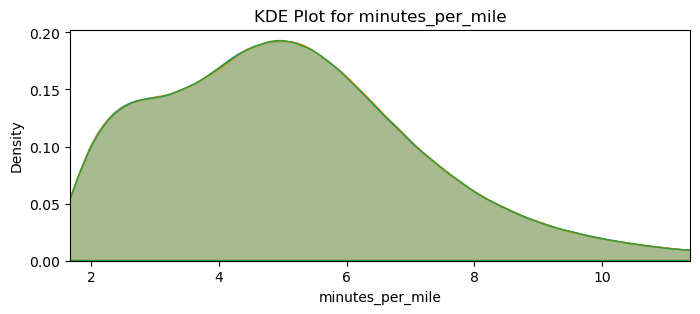

traffic


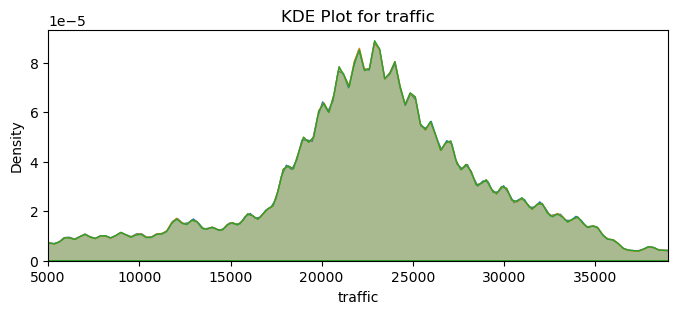

In [14]:
for column in numeric_cols:
    plt.figure(figsize=(8, 3))

    for s in seed:
        sample_data = combined_df.select(column).sample(False, 0.1, seed=s).toPandas()

        max_value = np.percentile(sample_data[column], 99)
        min_value = np.percentile(sample_data[column], 1)

        sns.kdeplot(sample_data[column], fill=True)
        plt.title(f'KDE Plot for {column}')
        plt.xlim(min_value, max_value)

    # Show the plot
    print(column)
    plt.show()

## 1.2 Categorical variables

### 1.2.1 Binary columns

In [15]:
binary_cols = ['shared_request_flag', 'shared_match_flag', 'access_a_ride_flag', 'wav_request_flag', 
               'wav_match_flag', 'any_tolls', 'RA','SN', 'DZ', 'TS', 'FG', 'FZ', 'CLR', 'BR']

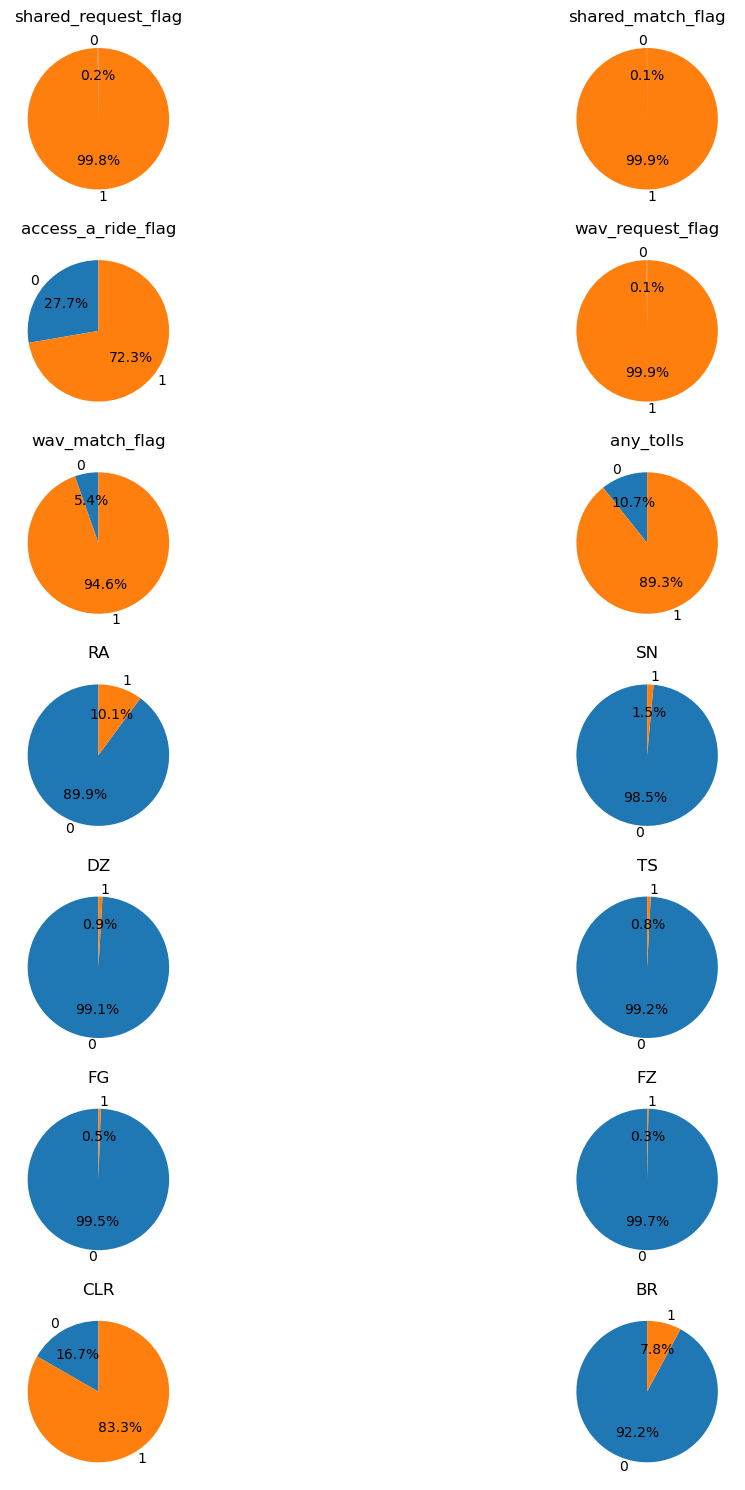

In [16]:
fig, axes = plt.subplots(7, 2, figsize=(15, 15))
axes = axes.flatten()

for i, column in enumerate(binary_cols):
    column_counts = combined_df.groupBy(column).count()
    column_counts_pandas = column_counts.toPandas()
    axes[i].pie(column_counts_pandas["count"], labels=column_counts_pandas.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [17]:
print("shared_request_flag: ", combined_df.filter(combined_df.shared_request_flag==1).count())
print("shared_match_flag: ", combined_df.filter(combined_df.shared_match_flag==1).count())
print("wav_request_flag: ", combined_df.filter(combined_df.wav_request_flag==1).count())
print("DZ: ", combined_df.filter(combined_df.DZ==1).count())
print("TS: ", combined_df.filter(combined_df.TS==1).count())
print("FG: ", combined_df.filter(combined_df.FG==1).count())
print("FZ: ", combined_df.filter(combined_df.FZ==1).count())

shared_request_flag:  25832
shared_match_flag:  9615


wav_request_flag:  21300


DZ:  151086


TS:  131938
FG:  88205


FZ:  47473


### 1.2.2 Nominal columns

In [18]:
nominal_cols = ['hour_of_day', 'taxi_company', 'dispatching_base_num', 'day_of_week', 'month', 'PUBorough',
                 'DOBorough', 'PUservice_zone', 'DOservice_zone','Holiday', "wind_direction", "skyc1", "skyc2", "skyc3"
               'PUservice_zone', 'DOservice_zone', 'visibility', 'precipitation', 'snowdepth']

In [19]:
low_nominal = ['taxi_company', 'PUBorough', 'DOBorough', "skyc1", "skyc2", "skyc3", 'PUservice_zone', 'DOservice_zone', 'visibility', 'precipitation', 'snowdepth']

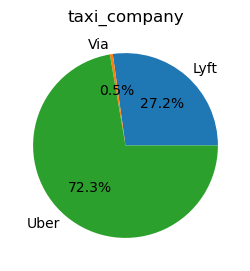

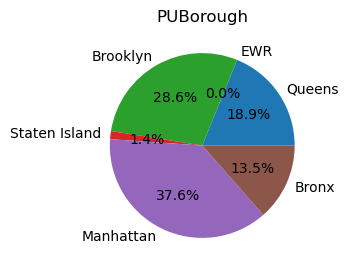

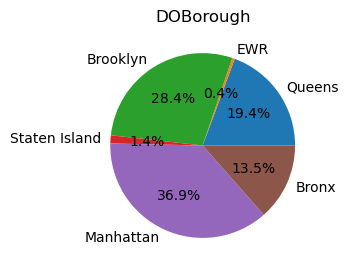

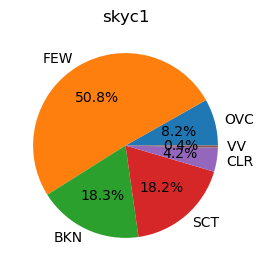

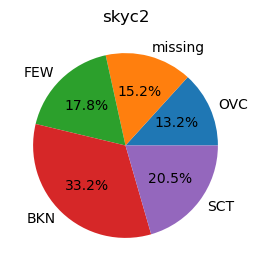

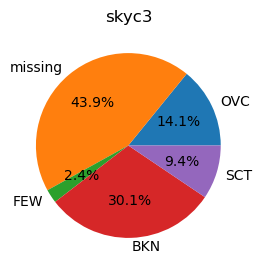

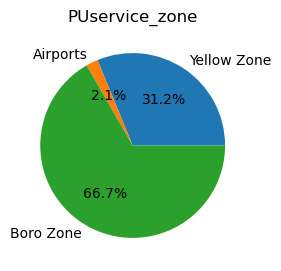

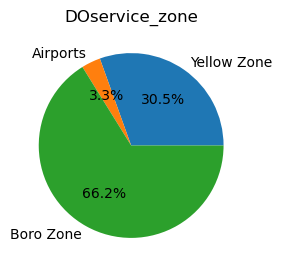

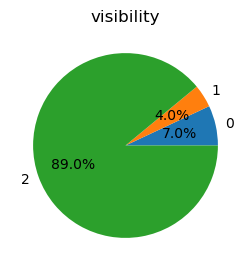

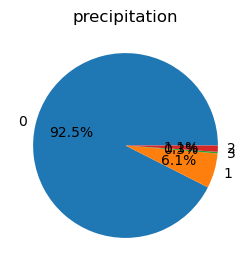

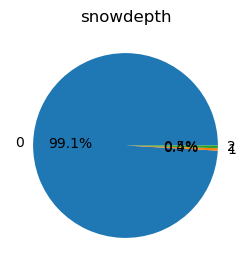

In [20]:
for column in low_nominal:
    plt.figure(figsize=(3, 3))    
    column_counts = combined_df.groupBy(column).count()
    column_counts_pandas = column_counts.toPandas()

    plt.pie(column_counts_pandas["count"], labels=column_counts_pandas[column], autopct='%1.1f%%')
    plt.title(column)
    plt.show()

In [21]:
print("taxi_company -> Via: ", combined_df.filter(combined_df.taxi_company=='Via').count())
print("skyc1 -> VV: ", combined_df.filter(combined_df.skyc1=='VV ').count())

taxi_company -> Via:  82810
skyc1 -> VV:  61252


In [22]:
print("EWR PUBorough: ", combined_df.filter(combined_df.PUBorough=='EWR').count())
print("EWR DOBorough: ", combined_df.filter(combined_df.DOBorough=='EWR').count())

EWR PUBorough:  210


EWR DOBorough:  73061


In [23]:
hour_df = combined_df.groupBy("pickup_date","hour_of_day").count().toPandas()

In [24]:
hour_df = hour_df.groupby('hour_of_day').agg({"count":['mean', 'median']})
hour_df.columns = hour_df.columns.droplevel(0)
hour_df = hour_df.reset_index()

<Axes: xlabel='hour_of_day'>

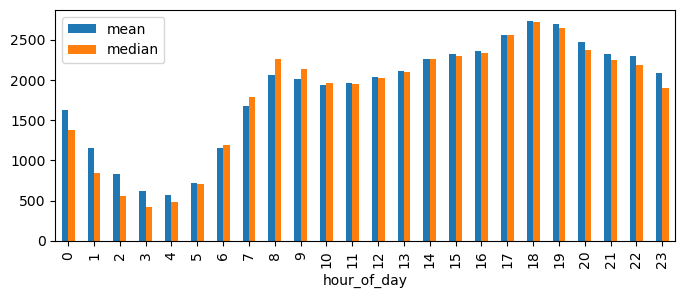

In [25]:
hour_df.plot(x='hour_of_day', y=['mean', 'median'], kind = 'bar', figsize=(8,3))

<Axes: xlabel='day_of_week'>

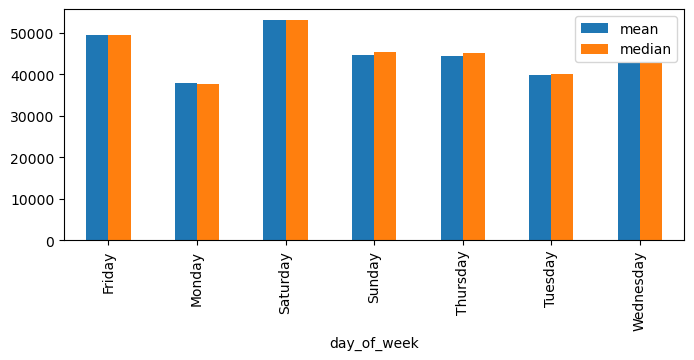

In [26]:
weekday_df = combined_df.groupBy("pickup_date","day_of_week").count().toPandas()

weekday_df = weekday_df.groupby('day_of_week').agg({"count":['mean', 'median']})
weekday_df.columns = weekday_df.columns.droplevel(0)
weekday_df = weekday_df.reset_index()

weekday_df.plot(x='day_of_week', y=['mean', 'median'], kind = 'bar', figsize=(8,3))

<Axes: xlabel='month'>

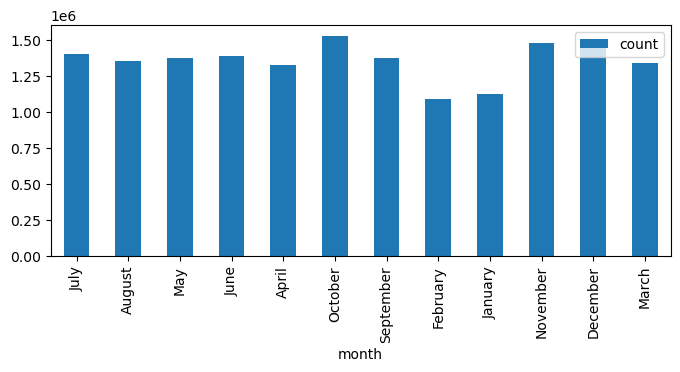

In [27]:
month_df = combined_df.groupBy("month").count().toPandas()
month_df.plot(x='month', y="count", kind = 'bar', figsize=(8,3))

In [28]:
holiday_df = combined_df.groupBy("Holiday").count().toPandas()
holiday_df.head()

Holiday     count
0                NA  15807374
1  Independence Day     37629
2      Memorial Day     35984
3      Columbus Day     38343
4         Labor Day     37232

In [29]:
holiday_df.loc[holiday_df['Holiday'] == 'NA', 'count'] /= 354

<Axes: xlabel='Holiday'>

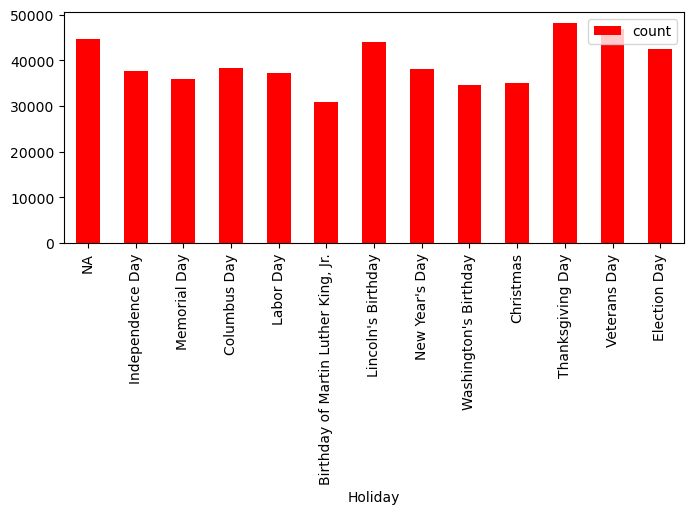

In [30]:
holiday_df.plot(x='Holiday', y="count", kind = 'bar', figsize=(8,3), color='red')

<Axes: xlabel='wind_direction'>

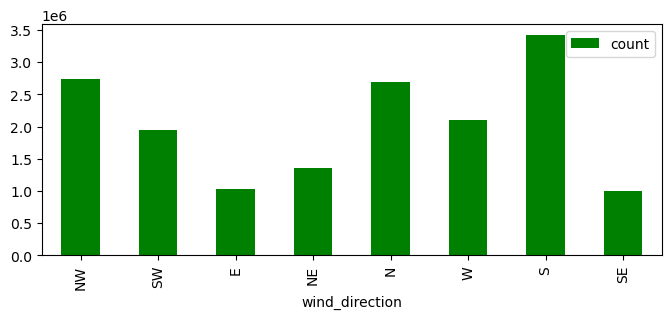

In [31]:
holiday_df = combined_df.groupBy("wind_direction").count().toPandas()
holiday_df.plot(x='wind_direction', y="count", kind = 'bar', figsize=(8,3), color='green')

### 1.2.3 High number of categorical values

In [32]:
high_categories = ['PULocationID', 'DOLocationID', 'dispatching_base_num']

In [33]:
dbn = combined_df.groupBy("dispatching_base_num").count().toPandas()

In [34]:
dbn.sort_values('count').head()

dispatching_base_num  count
1                B03136   1475
16               B02844   3170
11               B02512  34661
22               B02800  81335
29               B02865  85290

In [35]:
pul = combined_df.groupBy("PULocationID").count().toPandas()
pul.sort_values('count').head()

PULocationID  count
103             1    210
229            99    409
159             8    721
119           111    752
218            30    901

In [36]:
dol = combined_df.groupBy("DOLocationID").count().toPandas()
dol.sort_values('count').head()

DOLocationID  count
229            99    417
159             8    733
119           111    827
218            30    960
86            253   1086

# 2. Bivariate analysis

## 2.1 Numeric columns bivariate with minutes_per_mile

In [37]:
numeric_cols = ['traffic', 'humidity', 'wind_speed', 'pressure', 'feel', 'avg_skyl']

In [38]:
def bivariate(df, col1, col2):
    df2 = df.groupBy('pickup_date', 'hour_of_day').agg({col1: 'mean', col2:'mean'}).toPandas()
    df2.plot.hexbin(x=f'avg({col1})', y=f'avg({col2})')
    plt.show()
    print("\nPearson")
    sns.heatmap(df2[[f'avg({col1})',f'avg({col2})']].corr(), cmap="YlGnBu", annot=True) 
    plt.show() 
    print("\nSpearman")
    sns.heatmap(df2[[f'avg({col1})',f'avg({col2})']].corr(method = 'spearman'), cmap="YlGnBu", annot=True) 
    plt.show() 
    
    print("\nDistance correlation:\t",dcor.distance_correlation(df2[f'avg({col1})'], df2[f'avg({col2})']))

**traffic**

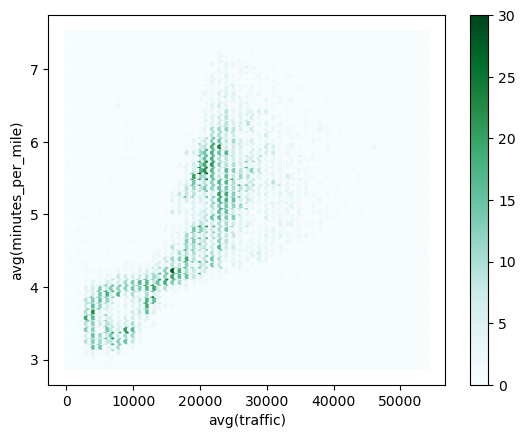


Pearson


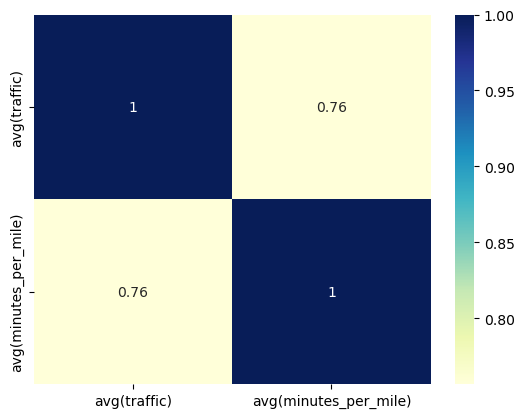


Spearman


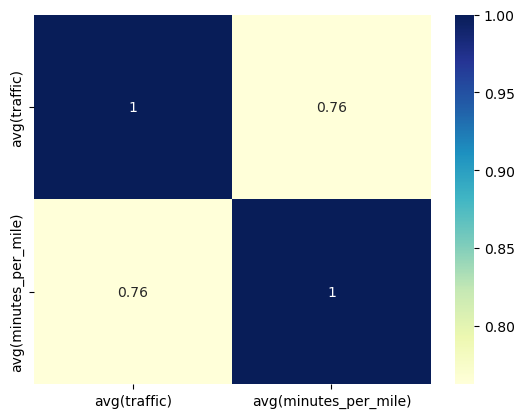


Distance correlation:	 0.7994899964643764


In [39]:
bivariate(combined_df, "traffic", "minutes_per_mile")

**humidity**

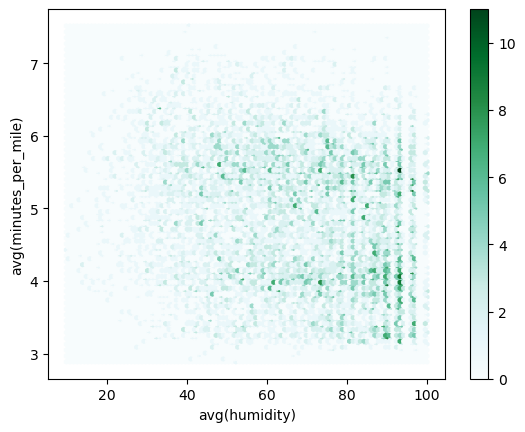


Pearson


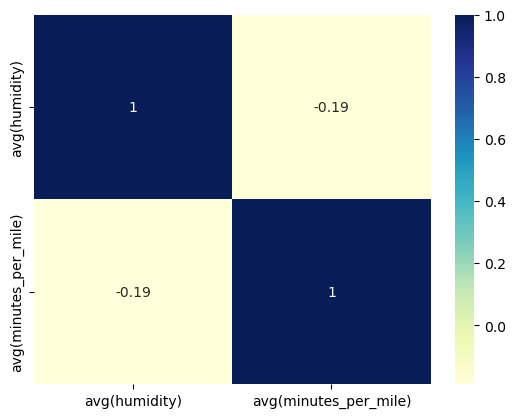


Spearman


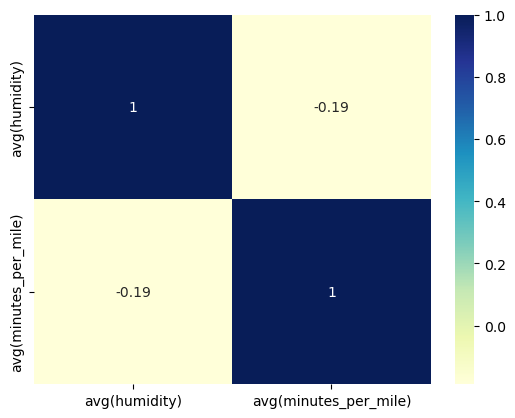


Distance correlation:	 0.17470159333691104


In [40]:
bivariate(combined_df, "humidity", "minutes_per_mile")

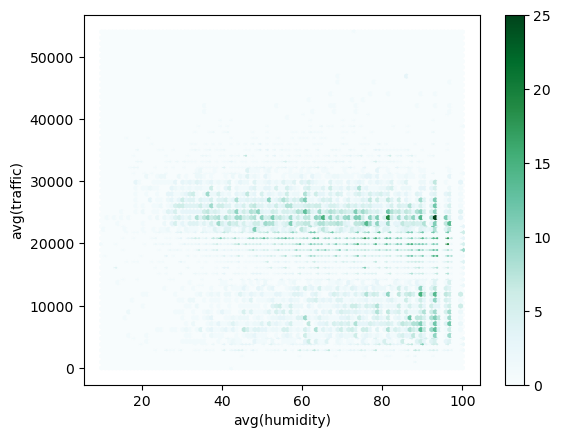


Pearson


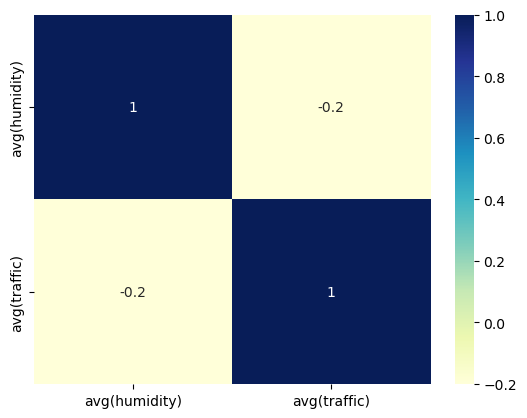


Spearman


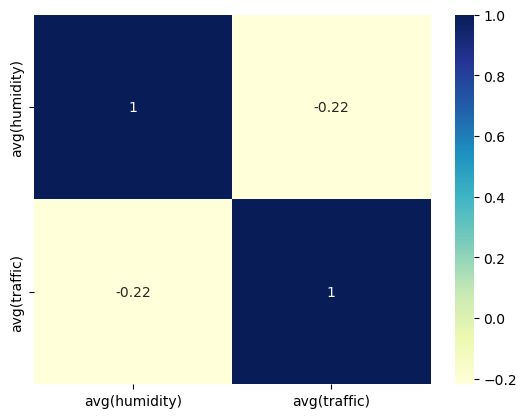


Distance correlation:	 0.19921381420461473


In [41]:
bivariate(combined_df, "humidity", "traffic")

checking humidity correlation with humidity

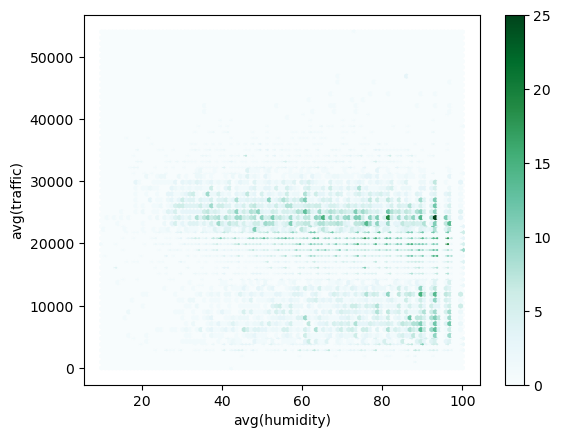


Pearson


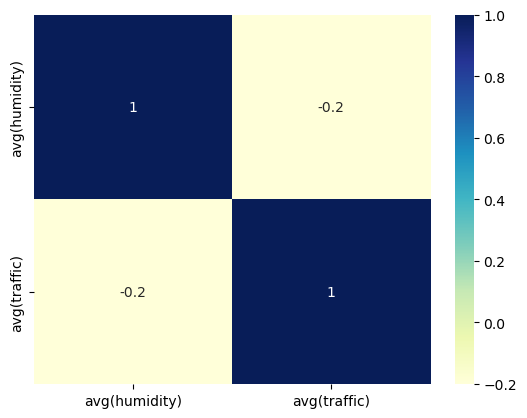


Spearman


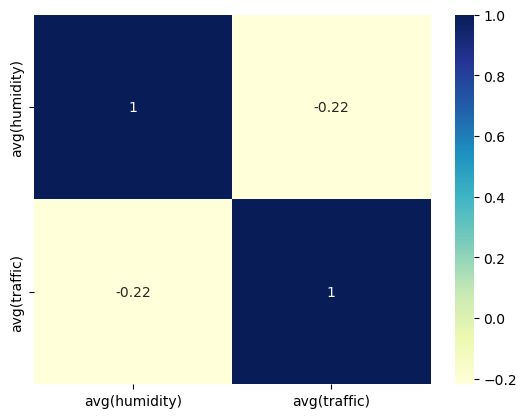


Distance correlation:	 0.19921381420461473


In [42]:
bivariate(combined_df, "humidity", "traffic")

**wind_speed**

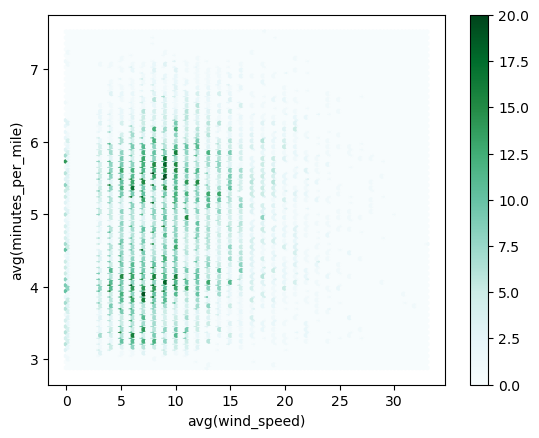


Pearson


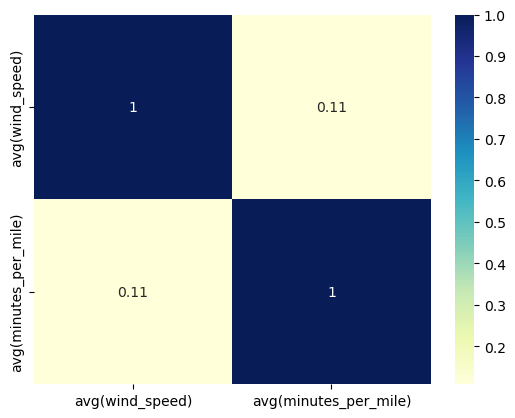


Spearman


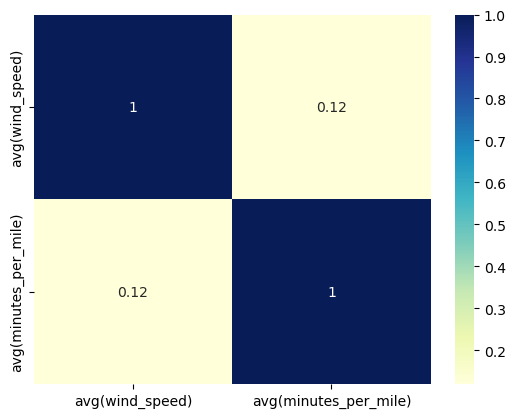


Distance correlation:	 0.11341542945934442


In [43]:
bivariate(combined_df, "wind_speed", "minutes_per_mile")

**pressure**

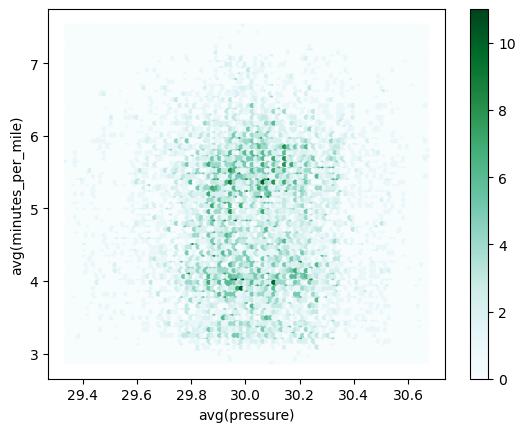


Pearson


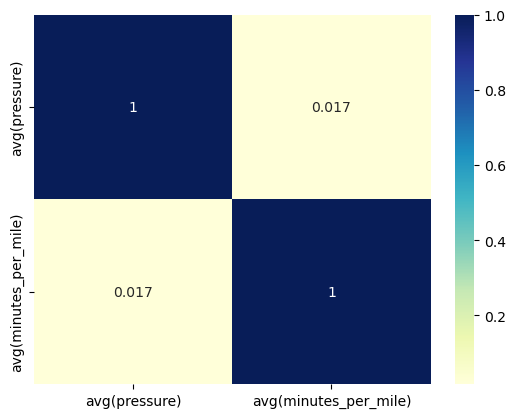


Spearman


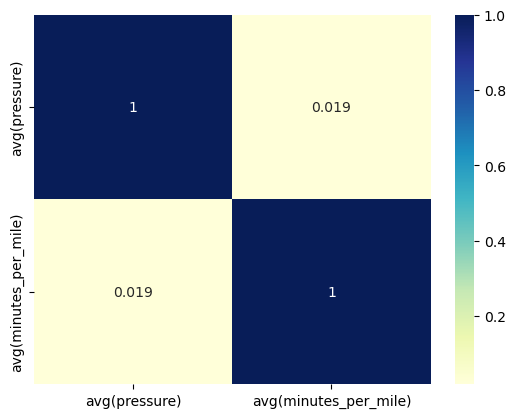


Distance correlation:	 0.033236331810788215


In [44]:
bivariate(combined_df, "pressure", "minutes_per_mile")

**feel**

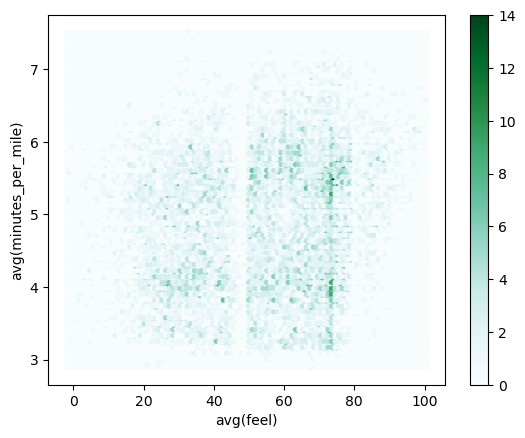


Pearson


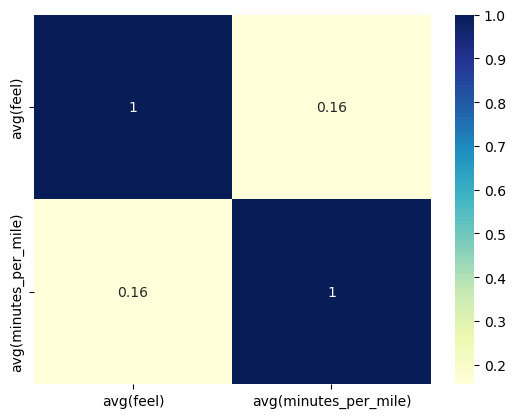


Spearman


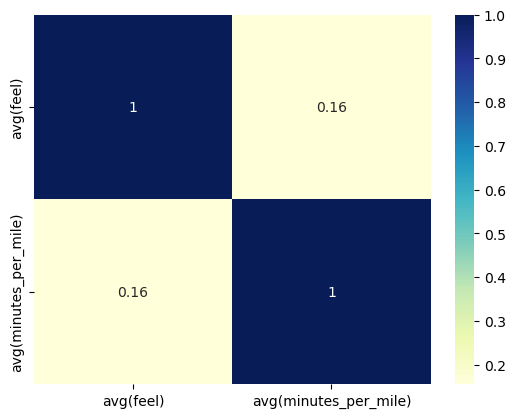


Distance correlation:	 0.14769008129791195


In [45]:
bivariate(combined_df, "feel", "minutes_per_mile")

Dividing feel to check difference and it's correlation with traffic

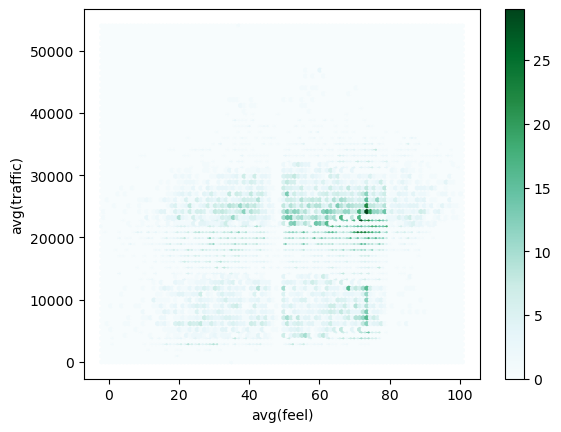


Pearson


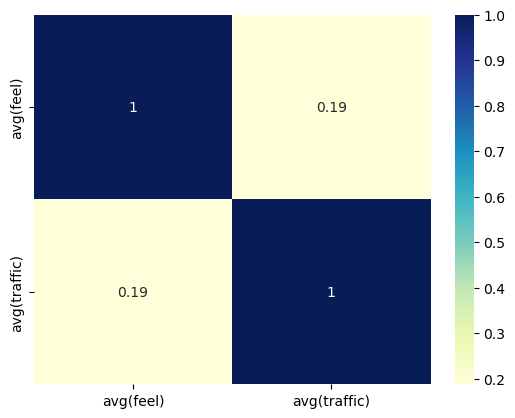


Spearman


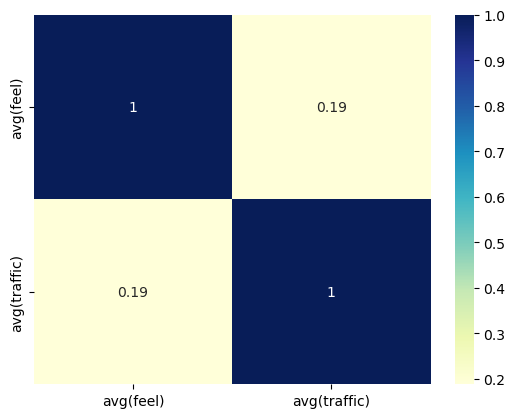


Distance correlation:	 0.1718770340462761


In [46]:
bivariate(combined_df, "feel", "traffic")

In [47]:
df1 = combined_df.select('feel', 'minutes_per_mile', 'traffic').filter(combined_df.feel<50).sample(False, 0.05).toPandas()
df2 = combined_df.select('feel', 'minutes_per_mile', 'traffic').filter(combined_df.feel>50).sample(False, 0.05).toPandas()

In [48]:
t = df1['minutes_per_mile'].quantile(0.95)
df1 = df1[df1['minutes_per_mile']<t]
df2 = df2[df2['minutes_per_mile']<t]

In [49]:
df1.describe()

feel  minutes_per_mile        traffic
count  273341.000000     273341.000000  273341.000000
mean       31.698627          4.761152   21437.515777
std         9.460054          1.759009    7323.040287
min        -2.020000          0.902427    1000.000000
25%        25.160000          3.358696   18000.000000
50%        33.260000          4.730594   22000.000000
75%        39.140000          6.021846   26000.000000
max        48.900000          8.892586   54000.000000

In [50]:
df2.describe()

feel  minutes_per_mile        traffic
count  480010.000000     480010.000000  480010.000000
mean       68.420644          4.916030   23275.923418
std        10.529989          1.762925    6903.662087
min        51.100000          0.848635    3000.000000
25%        60.100000          3.532423   20000.000000
50%        68.000000          4.883450   23000.000000
75%        75.000000          6.195923   27000.000000
max       100.710000          8.892617   47000.000000

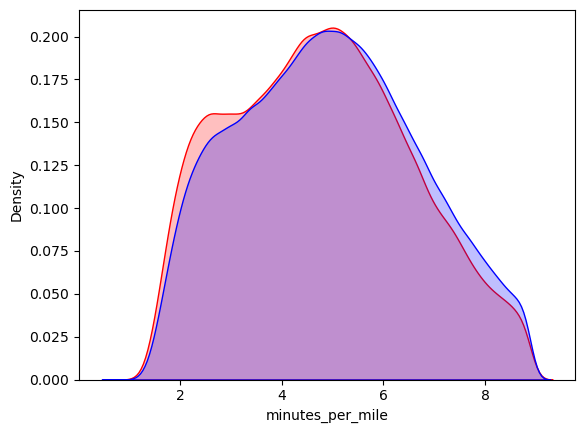

In [51]:
sns.kdeplot(df1['minutes_per_mile'], fill=True, color="r")
sns.kdeplot(df2['minutes_per_mile'], fill=True, color="b")
plt.show()

In [52]:
t = df1['traffic'].quantile(0.95)
df1 = df1[df1['traffic']<t]
df2 = df2[df2['traffic']<t]

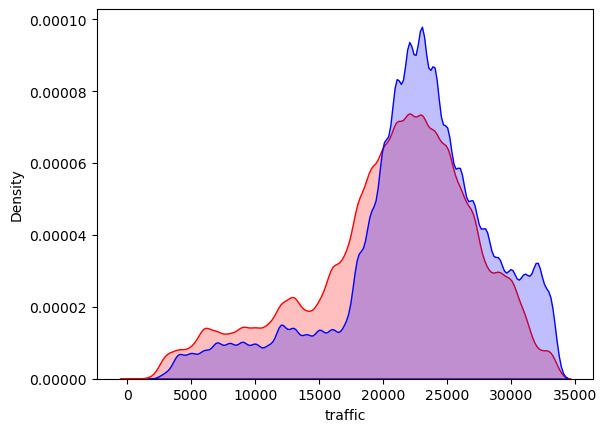

In [53]:
sns.kdeplot(df1['traffic'], fill=True, color="r")
sns.kdeplot(df2['traffic'], fill=True, color="b")
plt.show()

In [54]:
s0 = df1['traffic']
s1 = df2['traffic']

In [56]:
def cohen_d(group1, group2):

    mean1, mean2 = np.mean(group1), np.mean(group2)

    # Calculate pooled standard deviation
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_var = ((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2)
    pooled_sd = np.sqrt(pooled_var)

    cohen_d = (mean1 - mean2) / pooled_sd

    return cohen_d

In [57]:
print(f"s0: {np.std(s0)}")
print(f"s1: {np.std(s1)}")
        
print("\nCohen's d: ", cohen_d(s0, s1))
    
_, l_value = levene(s0, s1)
print("p-value:")
print("\nlevene test")
print("<0.05: ", l_value<0.05)
print("<0.01: ", l_value<0.01)    
    
t_stat, p_value = ttest_ind(s0, s1)
        
print("\nt-test:")
print("<0.05: ", p_value<0.05)
print("<0.01: ", p_value<0.01) 

s0: 6450.919996242553
s1: 6107.2205071699655

Cohen's d:  -0.28501638529193496
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


**avg_skyl**

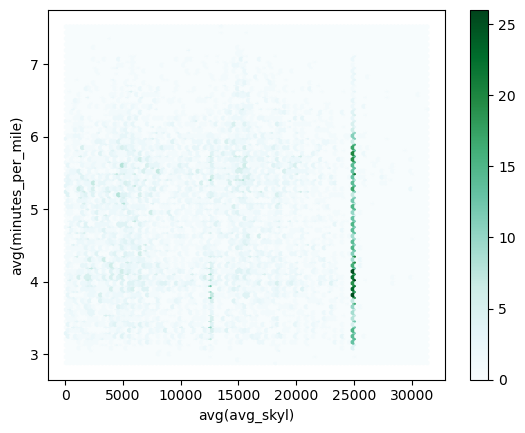


Pearson


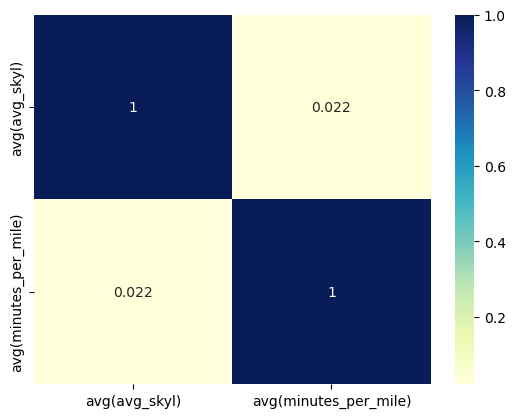


Spearman


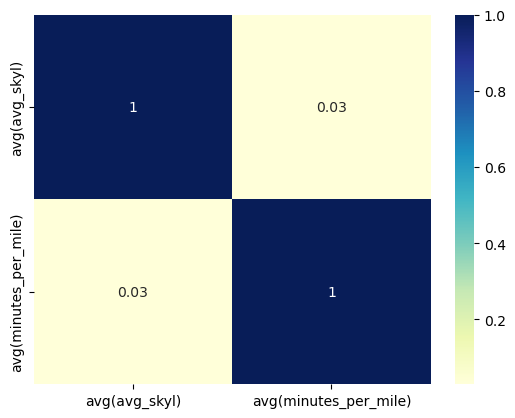


Distance correlation:	 0.05788461421486468


In [58]:
bivariate(combined_df, "avg_skyl", "minutes_per_mile")

## 2.2 Categorical columns bivariate with minutes_per_mile

### 2.2.1 Binary columns

In [59]:
binary_cols

['shared_request_flag',
 'shared_match_flag',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag',
 'any_tolls',
 'RA',
 'SN',
 'DZ',
 'TS',
 'FG',
 'FZ',
 'CLR',
 'BR']

In [60]:
def binary_bivariate(df, binary_col, numeric_col):
    
    # Boxplot
    sns.boxplot(x= binary_col, y=numeric_col, data=df)
    plt.show()
    
    # t-test
    s0 = df[df[binary_col] == 0][numeric_col]
    s1 = df[df[binary_col] == 1][numeric_col]
    
    print(f"s0: {np.std(s0)}")
    print(f"s1: {np.std(s1)}")
        
    print("\nCohen's d: ", cohen_d(s0, s1))
    
    _, l_value = levene(s0, s1)
    print("p-value:")
    print("\nlevene test")
    print("<0.05: ", l_value<0.05)
    print("<0.01: ", l_value<0.01)    
    
    t_stat, p_value = ttest_ind(s0, s1)
        
    print("\nt-test:")
    print("<0.05: ", p_value<0.05)
    print("<0.01: ", p_value<0.01)    
    


**access_a_ride_flag**

In [61]:
df1 = combined_df.select('access_a_ride_flag', 'minutes_per_mile').filter(combined_df.access_a_ride_flag==1)\
        .sample(False, 0.1).toPandas()
df0 = combined_df.select('access_a_ride_flag', 'minutes_per_mile').filter(combined_df.access_a_ride_flag==0)\
        .sample(False, 0.05).toPandas()

In [62]:
df2 = pd.concat([df1, df0])

In [63]:
t = df2['minutes_per_mile'].quantile(0.95)
df2 = df2[df2['minutes_per_mile']<t]

In [64]:
print(f"'access_a_ride_flag' == 1: {df2[df2['access_a_ride_flag']==1].shape[0]}")
print(f"'access_a_ride_flag' == 0: {df2[df2['access_a_ride_flag']==0].shape[0]}")

'access_a_ride_flag' == 1: 427728
'access_a_ride_flag' == 0: 560642


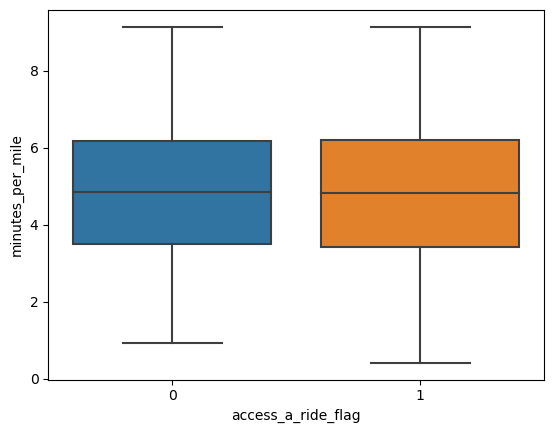

s0: 1.7886727932002144
s1: 1.8218016819697893

Cohen's d:  0.007458049078946498
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


In [65]:
binary_bivariate(df2, 'access_a_ride_flag', 'minutes_per_mile')

<Axes: xlabel='minutes_per_mile', ylabel='Density'>

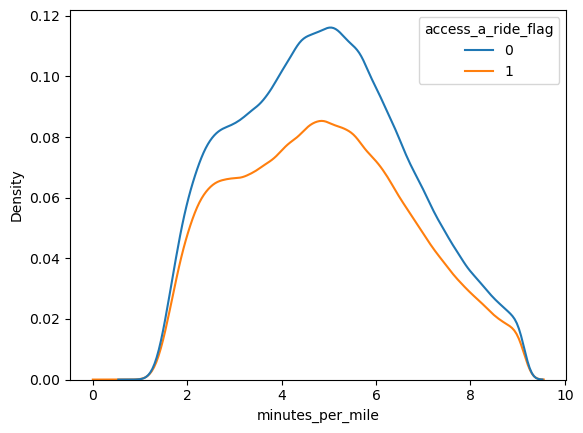

In [66]:
sns.kdeplot(data=df2, x="minutes_per_mile", hue="access_a_ride_flag")

**CLR**

In [67]:
df1 = combined_df.select('CLR', 'minutes_per_mile').filter(combined_df.CLR==1)\
        .sample(False, 0.05).toPandas()
df0 = combined_df.select('CLR', 'minutes_per_mile').filter(combined_df.CLR==0)\
        .sample(False, 0.1).toPandas()

In [68]:
df2 = pd.concat([df1, df0])

In [69]:
t = df2['minutes_per_mile'].quantile(0.95)
df2 = df2[df2['minutes_per_mile']<t]

In [70]:
print(f"'CLR' == 1: {df2[df2['CLR']==1].shape[0]}")
print(f"'CLR' == 0: {df2[df2['CLR']==0].shape[0]}")

'CLR' == 1: 642968
'CLR' == 0: 259610


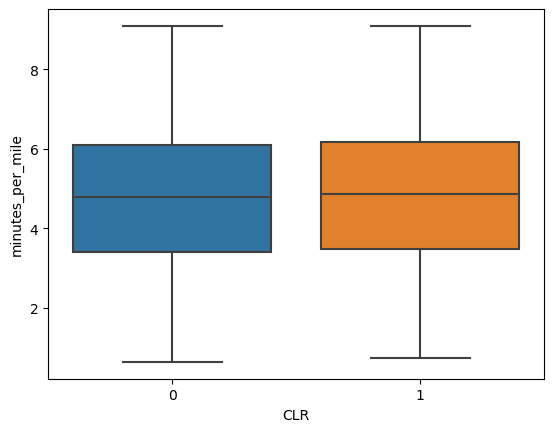

s0: 1.7778690625855702
s1: 1.7940667534602517

Cohen's d:  -0.04332476917083815
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


In [71]:
binary_bivariate(df2, 'CLR', 'minutes_per_mile')

<Axes: xlabel='minutes_per_mile', ylabel='Density'>

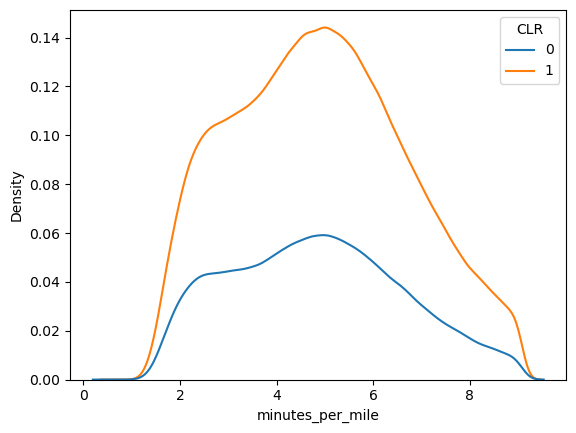

In [72]:
sns.kdeplot(data=df2, x="minutes_per_mile", hue="CLR")

In [73]:
def create_sample(df, binary_col, numeric_col):
    df1 = combined_df.select(binary_col, numeric_col).filter(combined_df[binary_col]==1)\
        .toPandas()
    df0 = combined_df.select(binary_col, numeric_col).filter(combined_df[binary_col]==0)\
        .sample(False, 0.05).toPandas()
    
    df2 = pd.concat([df1, df0])
    t = df2[numeric_col].quantile(0.95)
    df2 = df2[df2[numeric_col]<t]
    
    t = df2[numeric_col].quantile(0.05)
    df2 = df2[df2[numeric_col]>t]
    
    return df2

In [74]:
def perform_bivariate(df, bin_col, numeric_col):
    df2 = create_sample(df, bin_col, numeric_col)
    print(f"\033[1m'{bin_col}'\033[0m")
    
    print(f"{bin_col} == 1: {df2[df2[bin_col]==1].shape[0]}")
    print(f"{bin_col} == 0: {df2[df2[bin_col]==0].shape[0]}")
    
    binary_bivariate(df2, f'{bin_col}', numeric_col)
    
    f, axes = plt.subplots(1, 2)
    sns.kdeplot(data=df2[df2[bin_col]==0], color='blue', x=numeric_col, ax=axes[0])
    sns.kdeplot(data=df2[df2[bin_col]==1], color='orange', x=numeric_col, ax=axes[1])
    
    plt.show()

In [75]:
binary_cols.remove('access_a_ride_flag')
binary_cols.remove('CLR')

'shared_request_flag'
shared_request_flag == 1: 22695
shared_request_flag == 0: 734339


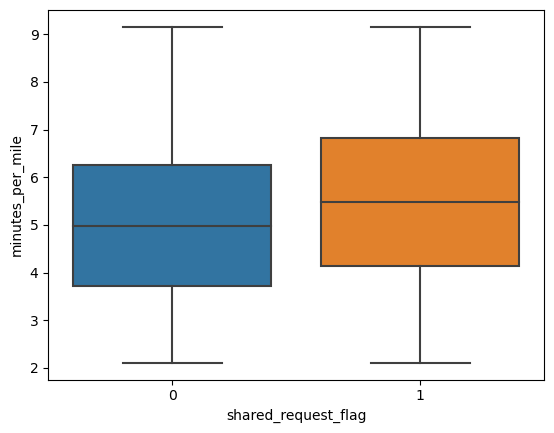

s0: 1.6963840007316437
s1: 1.7635190980010755

Cohen's d:  -0.25439467015783096
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


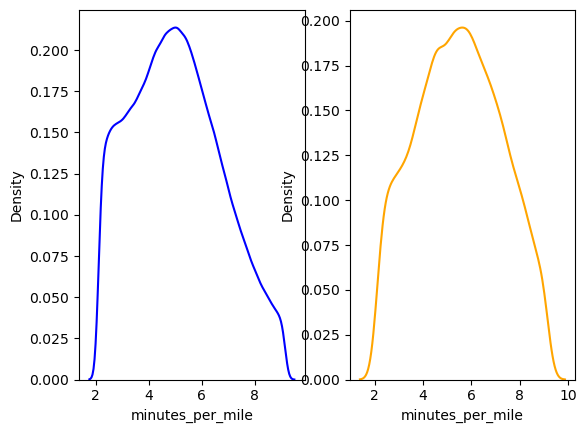

'shared_match_flag'
shared_match_flag == 1: 8392
shared_match_flag == 0: 734497


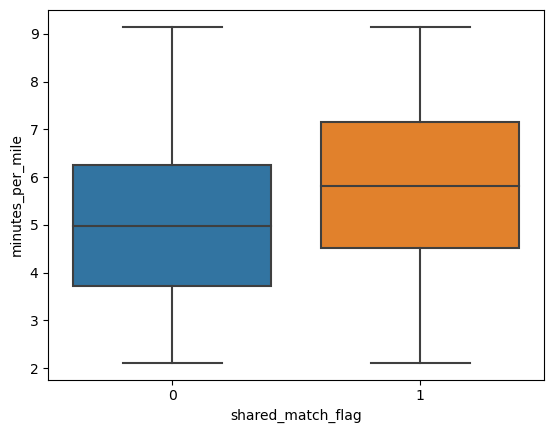

s0: 1.6972611664000128
s1: 1.7171580715747012

Cohen's d:  -0.44355793539426364
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


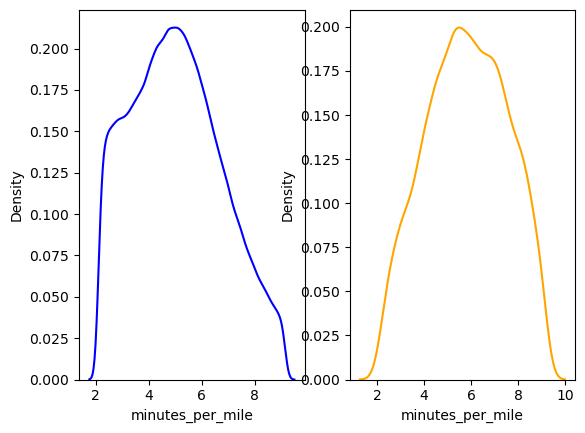

'wav_request_flag'
wav_request_flag == 1: 17202
wav_request_flag == 0: 736794


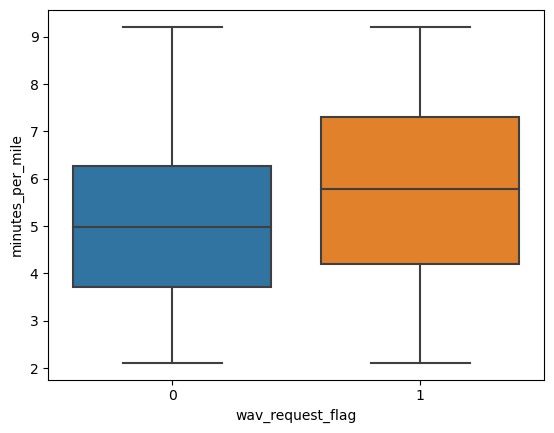

s0: 1.704980103989044
s1: 1.880548618270006

Cohen's d:  -0.39875916653586413
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


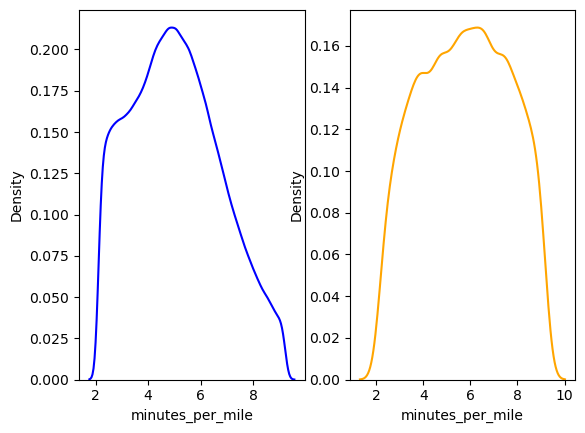

'wav_match_flag'
wav_match_flag == 1: 795735
wav_match_flag == 0: 692325


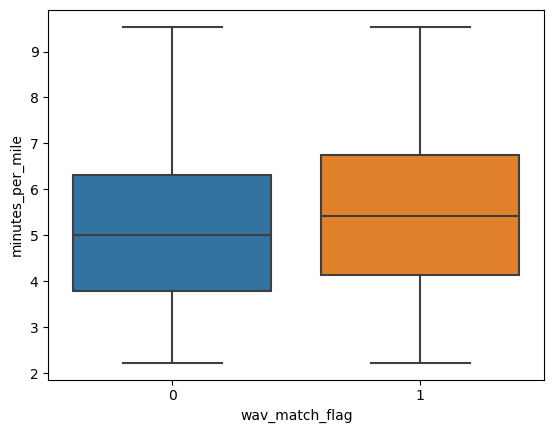

s0: 1.7206608365519398
s1: 1.7582503849643596

Cohen's d:  -0.20415183934466635
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


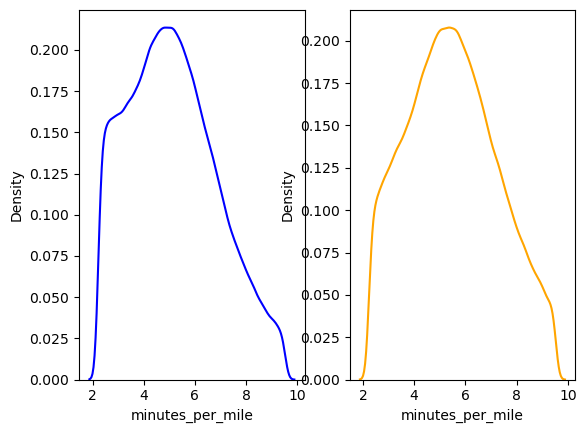

'any_tolls'
any_tolls == 1: 1604845
any_tolls == 0: 622379


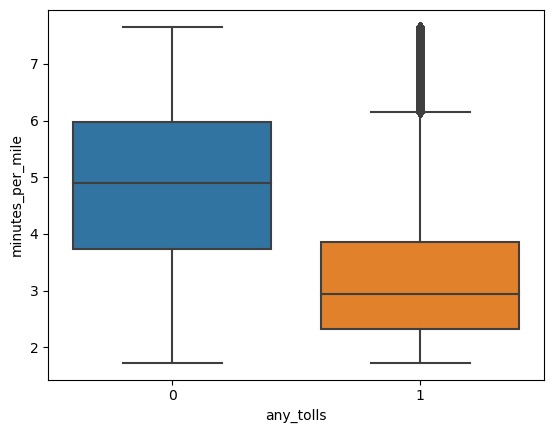

s0: 1.4644388991176904
s1: 1.1921205137146467

Cohen's d:  1.2527237640038476
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


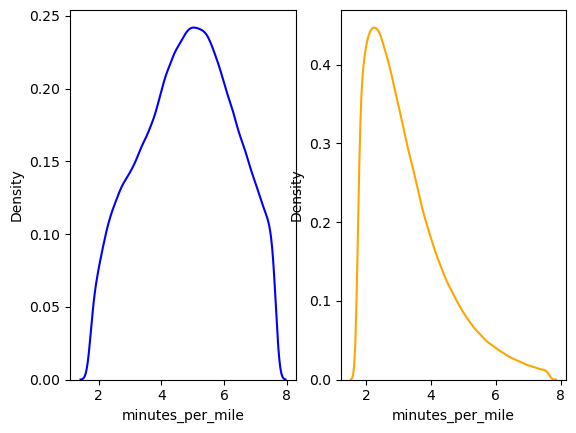

'RA'
RA == 1: 1486933
RA == 0: 659266


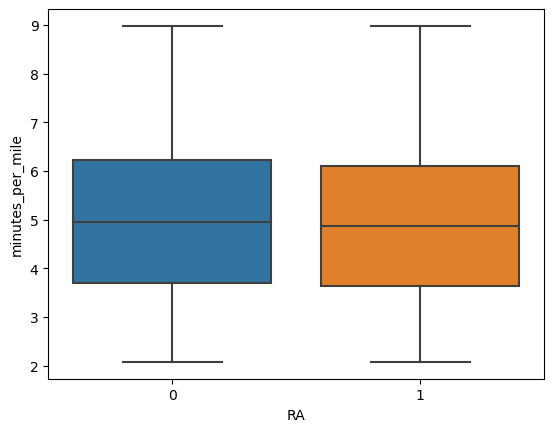

s0: 1.6835500873898501
s1: 1.6599358805829925

Cohen's d:  0.051911493808599225
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


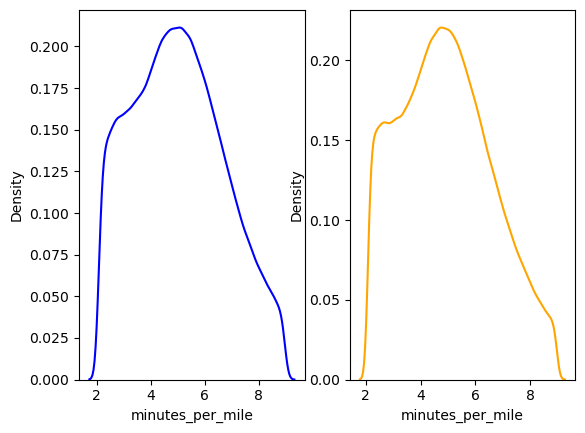

'SN'
SN == 1: 215338
SN == 0: 722293


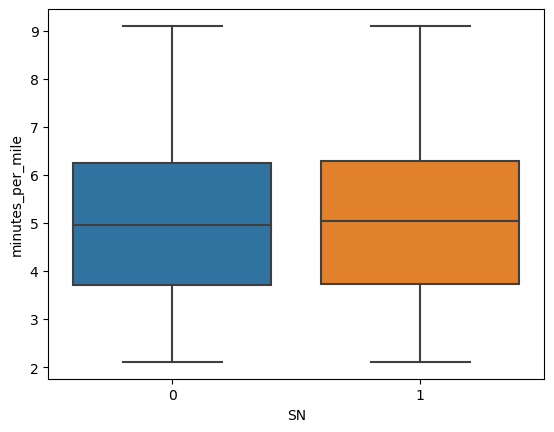

s0: 1.6873106683256196
s1: 1.691842595560368

Cohen's d:  -0.01940700156585822
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


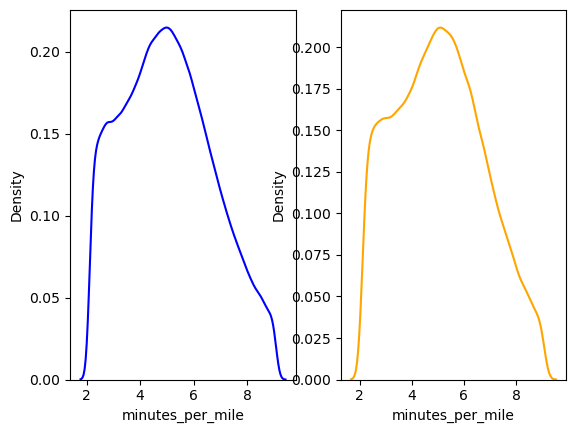

'DZ'
DZ == 1: 135687
DZ == 0: 727279


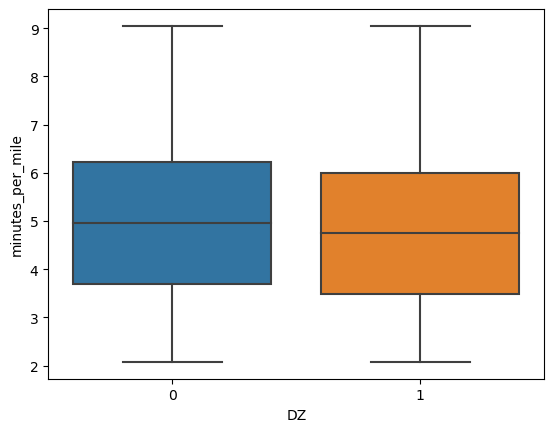

s0: 1.68926226028187
s1: 1.665069950320989

Cohen's d:  0.11601404226915328
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


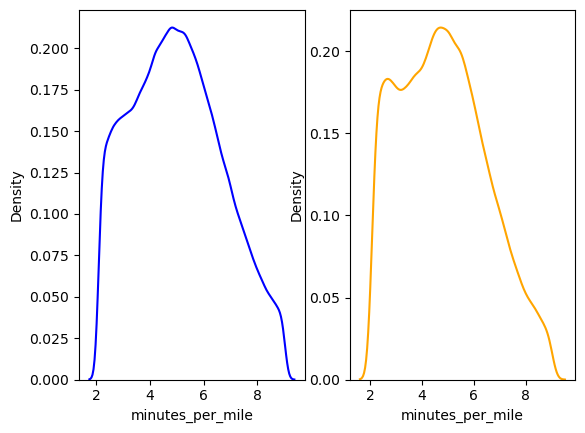

'TS'
TS == 1: 120561
TS == 0: 727264


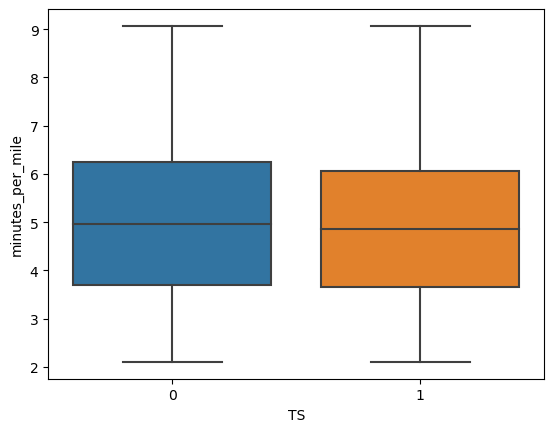

s0: 1.6869283306153102
s1: 1.6370283053639383

Cohen's d:  0.06197580282705216
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


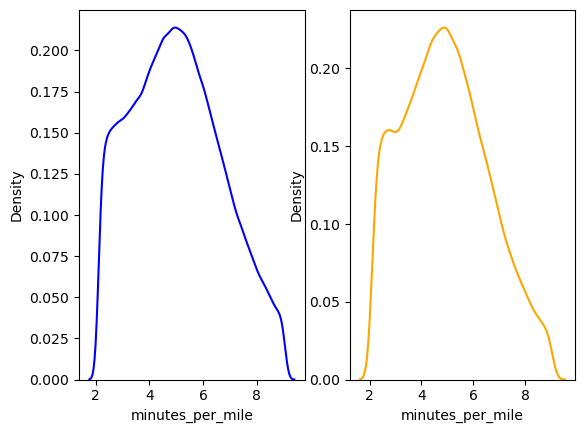

'FG'
FG == 1: 80086
FG == 0: 729202


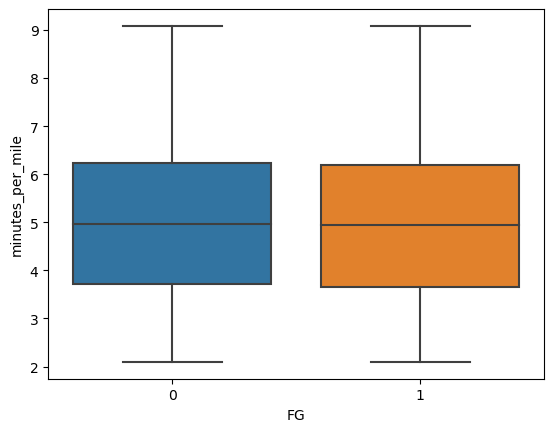

s0: 1.6887527239252982
s1: 1.6741553371952018

Cohen's d:  0.027414100050679492
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


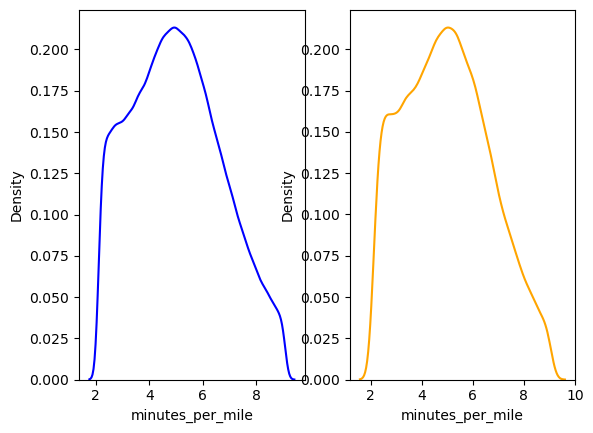

'FZ'
FZ == 1: 43274
FZ == 0: 731816


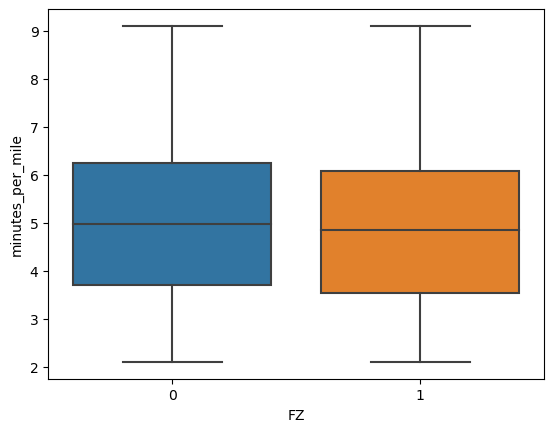

s0: 1.692026817103329
s1: 1.6677267504728543

Cohen's d:  0.08335391302432876
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


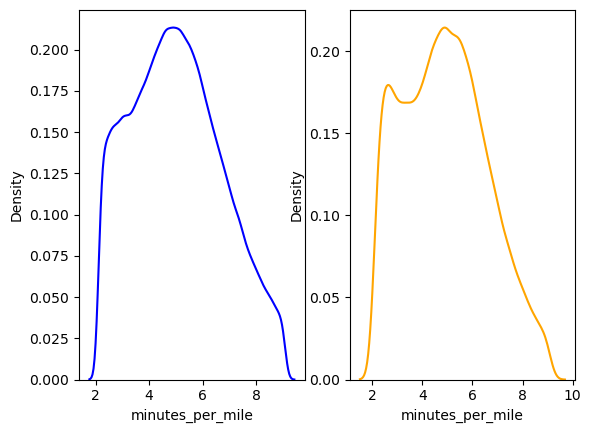

'BR'
BR == 1: 1147006
BR == 0: 676167


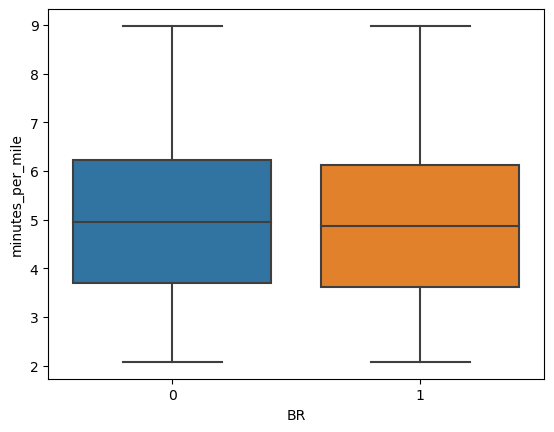

s0: 1.6804252707326897
s1: 1.6647803709243008

Cohen's d:  0.046783032843728846
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


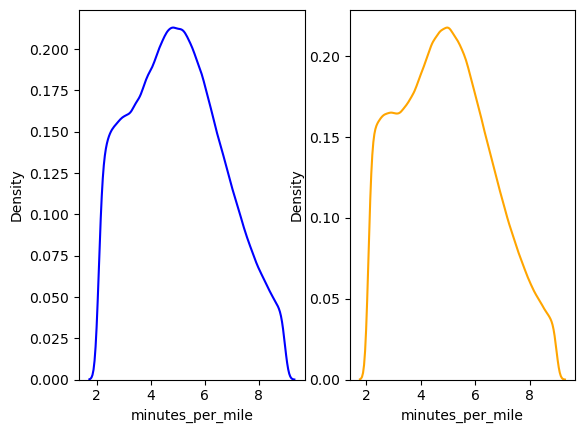

In [76]:
for bin_col in binary_cols:
    perform_bivariate(combined_df, bin_col, 'minutes_per_mile')

'shared_request_flag'
shared_request_flag == 1: 23167
shared_request_flag == 0: 717472


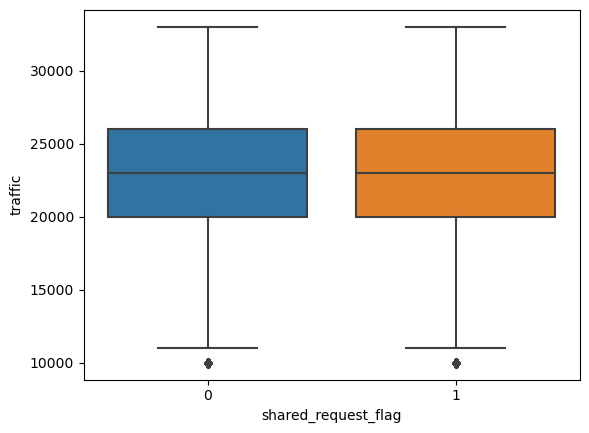

s0: 5052.375818132642
s1: 5134.070266147725

Cohen's d:  -0.002304567131072222
p-value:

levene test
<0.05:  False
<0.01:  False

t-test:
<0.05:  False
<0.01:  False


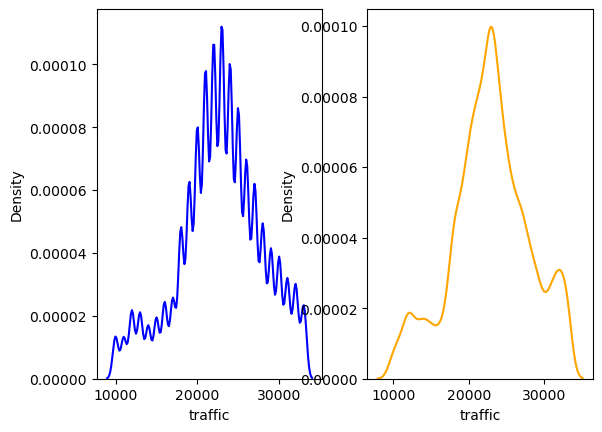

'shared_match_flag'
shared_match_flag == 1: 8652
shared_match_flag == 0: 719505


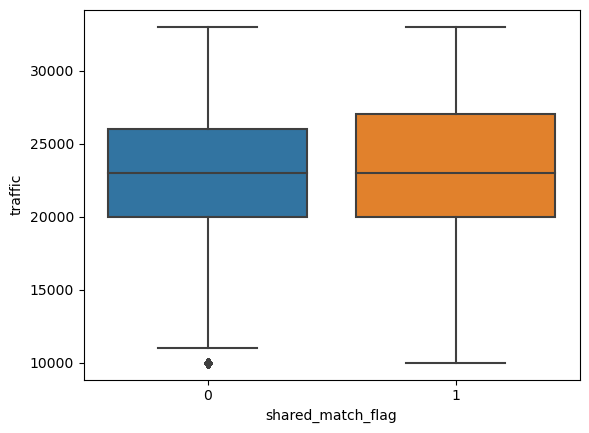

s0: 5045.803144298598
s1: 5152.186412087433

Cohen's d:  -0.07742584615794641
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


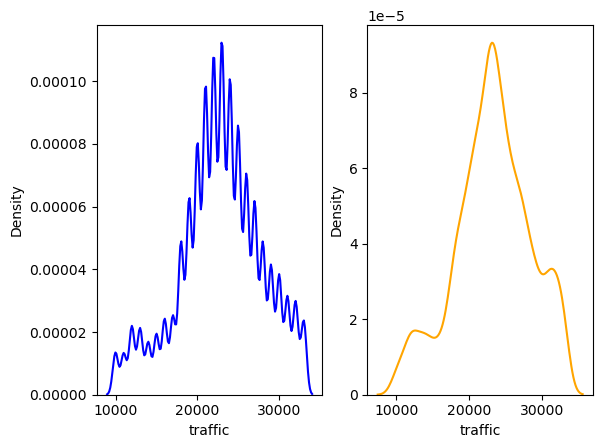

'wav_request_flag'
wav_request_flag == 1: 20227
wav_request_flag == 0: 718928


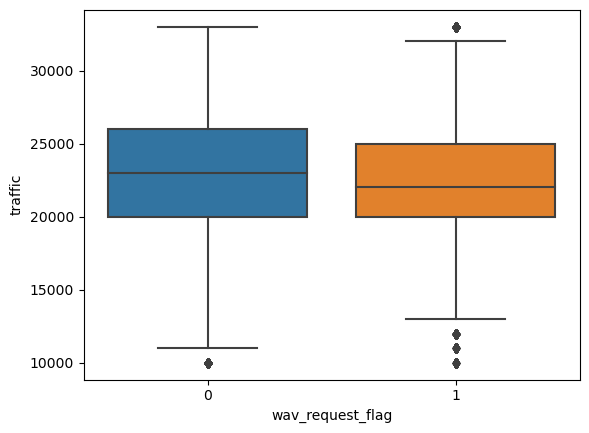

s0: 5051.378190360975
s1: 4038.5033038800943

Cohen's d:  0.039153380862118836
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


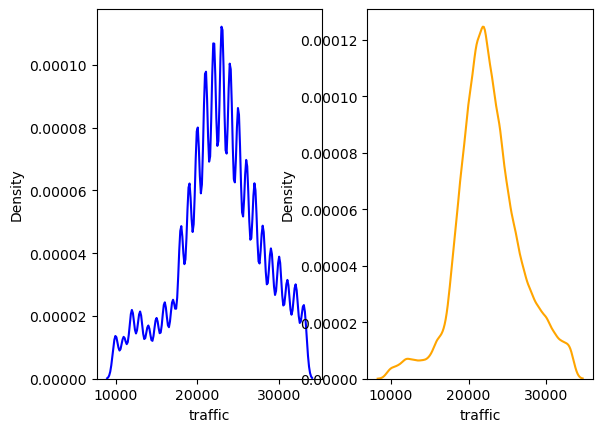

'wav_match_flag'
wav_match_flag == 1: 786119
wav_match_flag == 0: 681325


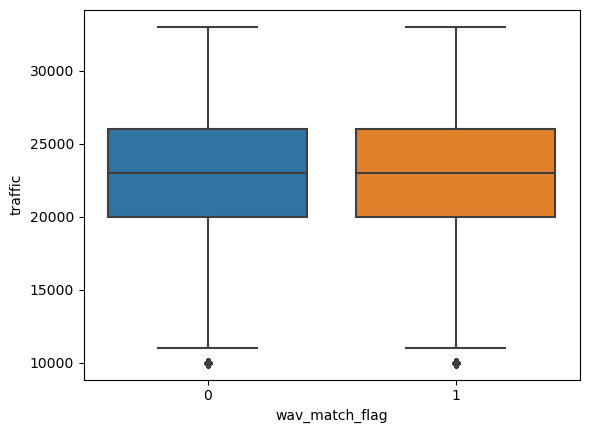

s0: 5049.318336835666
s1: 4924.011474370816

Cohen's d:  -0.05746676179853174
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


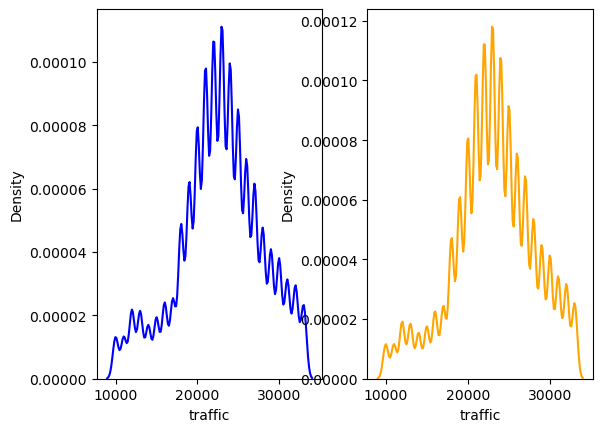

'any_tolls'
any_tolls == 1: 1540444
any_tolls == 0: 651027


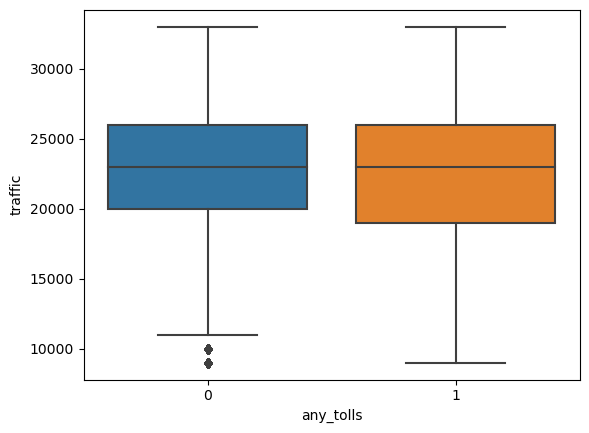

s0: 5210.622185386048
s1: 5437.376915364822

Cohen's d:  0.09422586951395426
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


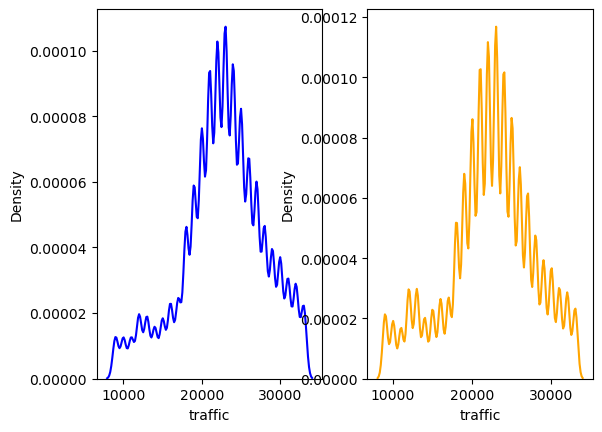

'RA'
RA == 1: 1448236
RA == 0: 656035


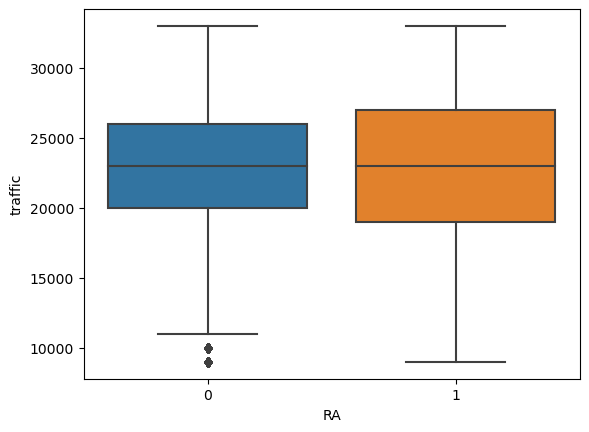

s0: 5198.047334923181
s1: 5529.907508138344

Cohen's d:  0.014323453075245232
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


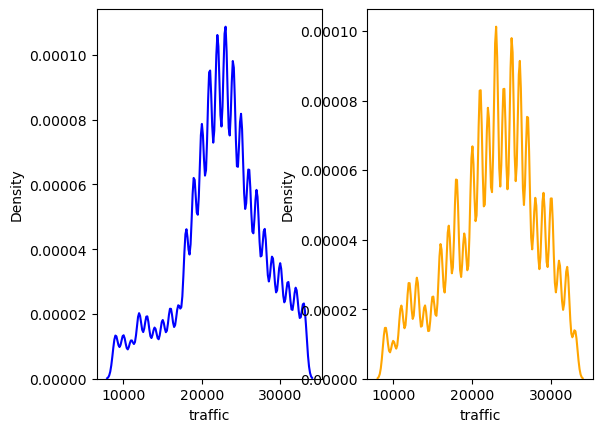

'SN'
SN == 1: 220237
SN == 0: 703014


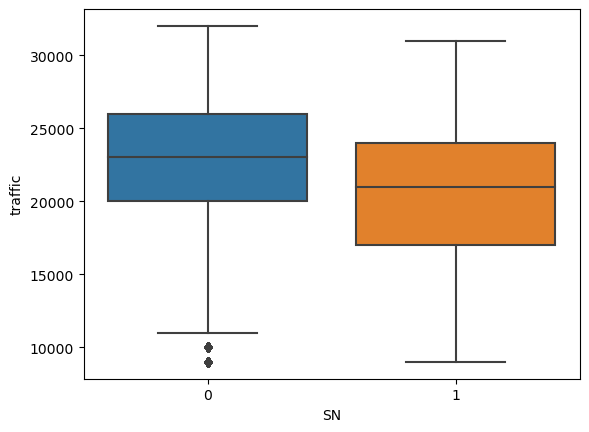

s0: 5072.180586714739
s1: 5125.637987831284

Cohen's d:  0.4288042111848366
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


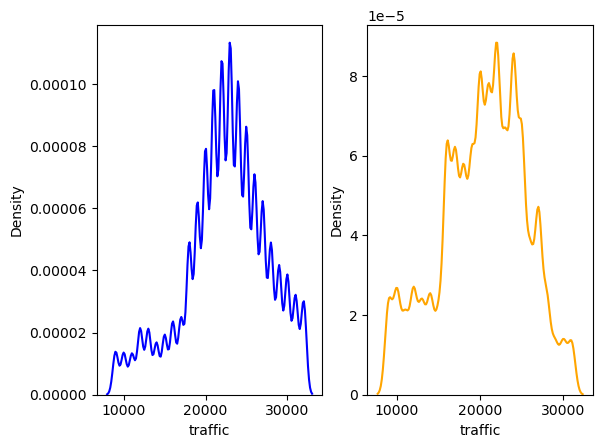

'DZ'
DZ == 1: 137622
DZ == 0: 723495


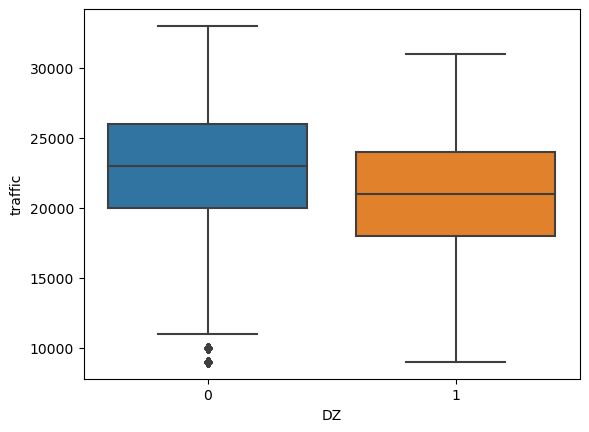

s0: 5223.620430034204
s1: 5314.942985209395

Cohen's d:  0.44298379097208
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


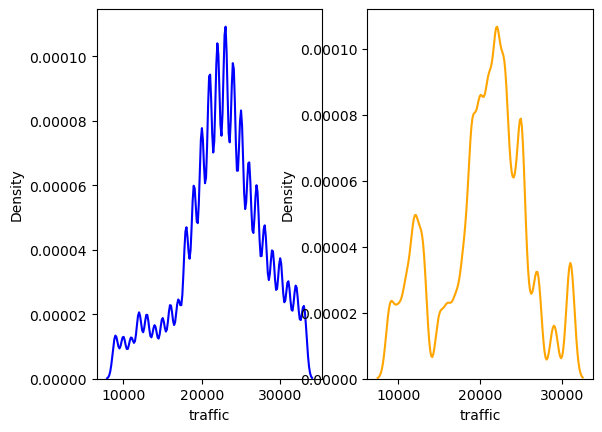

'TS'
TS == 1: 122289
TS == 0: 714376


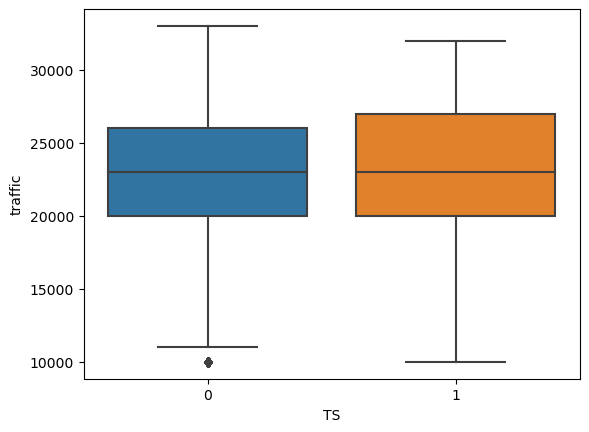

s0: 5045.2993854223205
s1: 5359.15493019954

Cohen's d:  -0.09648127273869059
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


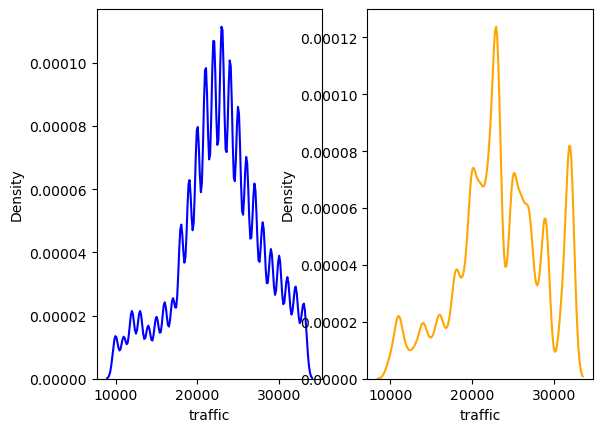

'FG'
FG == 1: 78667
FG == 0: 714257


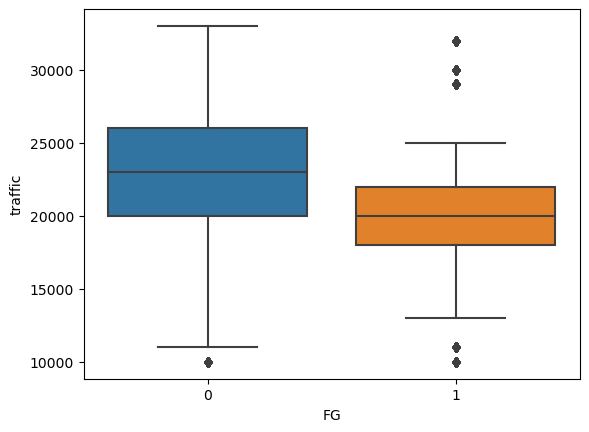

s0: 5040.934965026157
s1: 4942.170896344462

Cohen's d:  0.45580400715163166
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


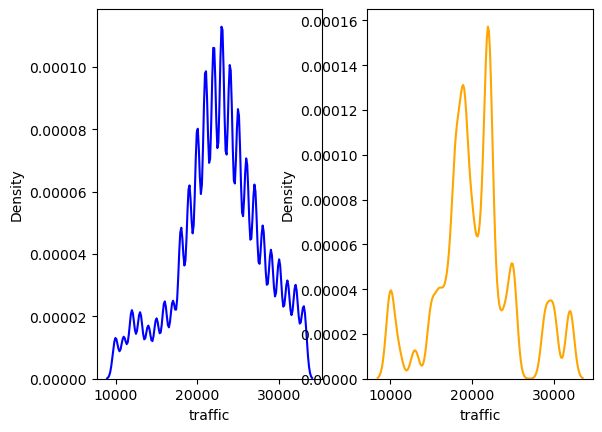

'FZ'
FZ == 1: 40732
FZ == 0: 716156


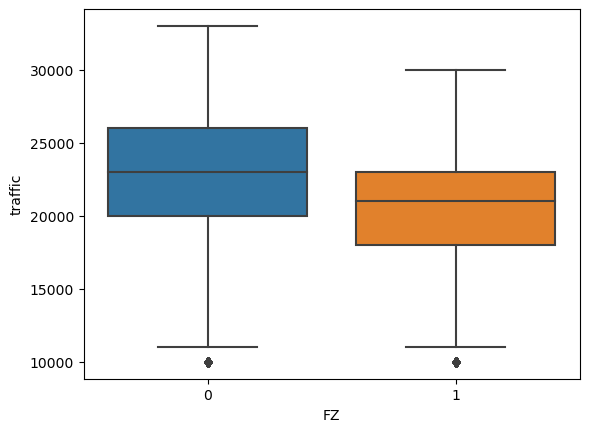

s0: 5048.7468892890365
s1: 4934.44893617696

Cohen's d:  0.46388089605533955
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


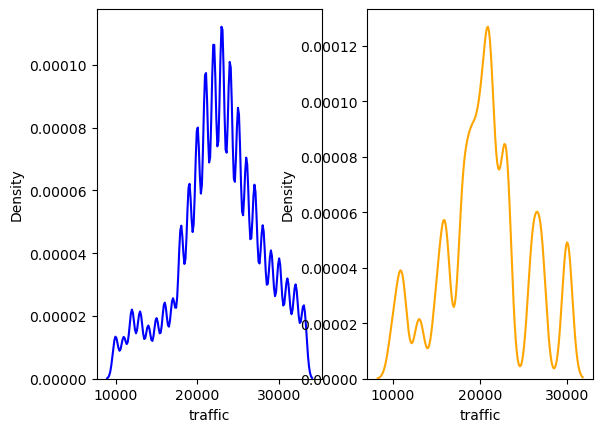

'BR'
BR == 1: 1139127
BR == 0: 671949


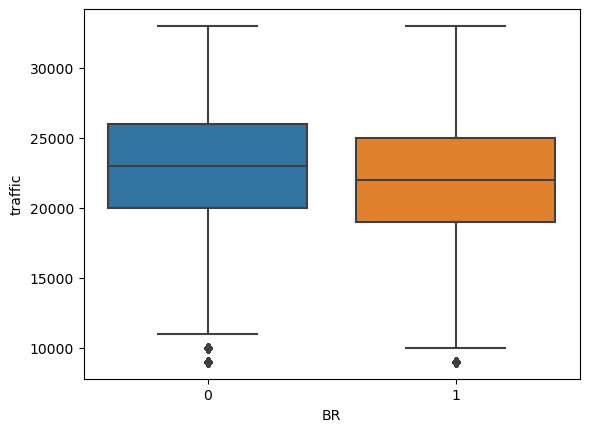

s0: 5219.365936148295
s1: 5244.5505325217655

Cohen's d:  0.23085530121668893
p-value:

levene test
<0.05:  True
<0.01:  True

t-test:
<0.05:  True
<0.01:  True


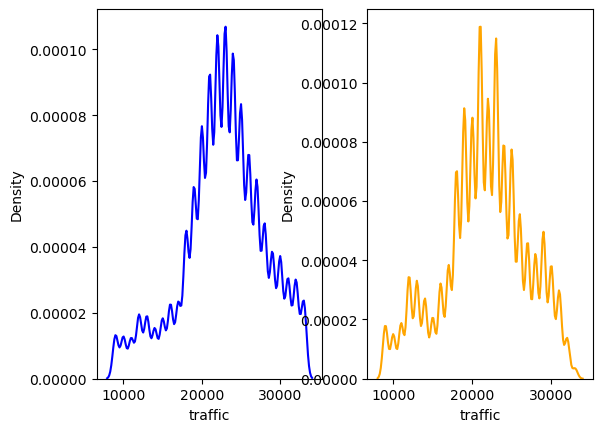

In [77]:
for bin_col in binary_cols:
    perform_bivariate(combined_df, bin_col, 'traffic')

- **Note:** *Just because a feature affects the traffic that doesn't necessarily mean it would affect the trip time. The reason for that is traffic might be carrying that information and adding the other feature might overfit the model.*

In [79]:
for bin_col in binary_cols:    
    df = create_sample(combined_df, bin_col, 'minutes_per_mile')
    
    # Welch's t-test
    s0 = df[df[bin_col] == 0]['minutes_per_mile']
    s1 = df[df[bin_col] == 1]['minutes_per_mile']
    
    print(f"\033[1m'{bin_col}'\033[0m")
    
    t_stat, p_value = ttest_ind(s0, s1, equal_var=False)
    print("<0.05: ", p_value<0.05)
    print("<0.01: ", p_value<0.01)

'shared_request_flag'
<0.05:  True
<0.01:  True


'shared_match_flag'
<0.05:  True
<0.01:  True


'wav_request_flag'
<0.05:  True
<0.01:  True


'wav_match_flag'
<0.05:  True
<0.01:  True


'any_tolls'
<0.05:  True
<0.01:  True


'RA'
<0.05:  True
<0.01:  True


'SN'
<0.05:  True
<0.01:  True


'DZ'
<0.05:  True
<0.01:  True


'TS'
<0.05:  True
<0.01:  True


'FG'
<0.05:  True
<0.01:  True


'FZ'
<0.05:  True
<0.01:  True


'BR'
<0.05:  True
<0.01:  True


### 2.2.2 Nominal columns

In [80]:
nominal_cols

['hour_of_day',
 'taxi_company',
 'dispatching_base_num',
 'day_of_week',
 'month',
 'PUBorough',
 'DOBorough',
 'PUservice_zone',
 'DOservice_zone',
 'Holiday',
 'wind_direction',
 'skyc1',
 'skyc2',
 'skyc3PUservice_zone',
 'DOservice_zone',
 'visibility',
 'precipitation',
 'snowdepth']

In [81]:
# Columns with few categories
low_nominal

['taxi_company',
 'PUBorough',
 'DOBorough',
 'skyc1',
 'skyc2',
 'skyc3',
 'PUservice_zone',
 'DOservice_zone',
 'visibility',
 'precipitation',
 'snowdepth']

In [82]:
def nominal_bivariate_analysis(data, nominal_col, numeric_col):
    df = data.select(nominal_col, numeric_col).sample(False, 0.05).toPandas()
    
    t = df[numeric_col].quantile(0.95)
    df = df[df[numeric_col]<t]
    
    print(f"\033[1m{nominal_col}\033[0m")
    sns.kdeplot(data=df, x=numeric_col, hue=nominal_col)
    plt.show()
    
    nominal_list = df[nominal_col].unique()
    pairs= []
    
    for i,b in enumerate(nominal_list):
        for j in range(i+1, len(nominal_list)):
            pairs.append([nominal_list[i], nominal_list[j]])
            
    for p in pairs:
        print(p, end=" ")
        print(f": {cohen_d(df[df[nominal_col]==p[0]][numeric_col], df[df[nominal_col]==p[1]][numeric_col])}")

taxi_company


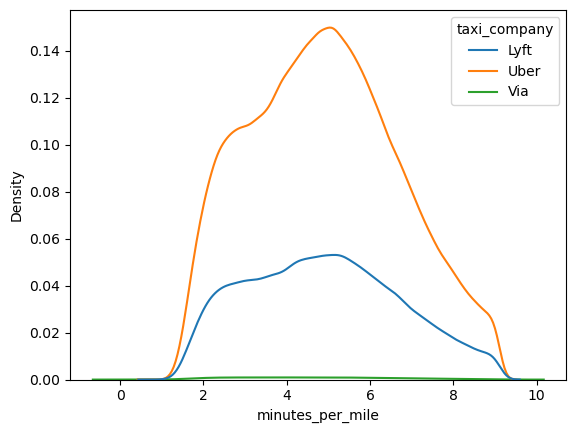

['Lyft', 'Uber'] : -0.006935522479492024
['Lyft', 'Via'] : 0.11483356201979864
['Uber', 'Via'] : 0.12407797830278969


PUBorough


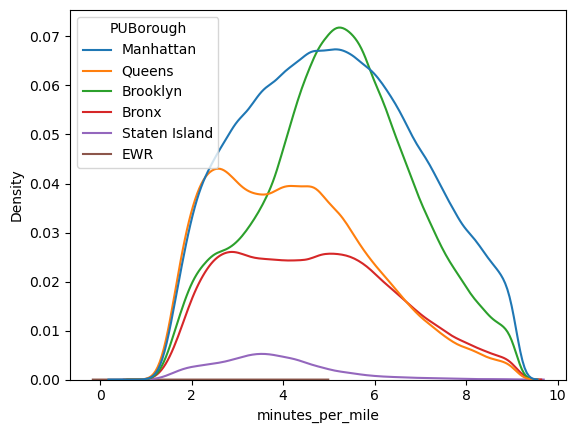

['Manhattan', 'Queens'] : 0.46334248195091304
['Manhattan', 'Brooklyn'] : -0.052851507046239504
['Manhattan', 'Bronx'] : 0.219646157676052
['Manhattan', 'Staten Island'] : 0.742966028679543
['Manhattan', 'EWR'] : 1.5661433996073304
['Queens', 'Brooklyn'] : -0.5551095067080257
['Queens', 'Bronx'] : -0.2483041248849592
['Queens', 'Staten Island'] : 0.31652596046748677
['Queens', 'EWR'] : 1.2194854113025138
['Brooklyn', 'Bronx'] : 0.2923990011865344
['Brooklyn', 'Staten Island'] : 0.8891405122234896
['Brooklyn', 'EWR'] : 1.811237023038388
['Bronx', 'Staten Island'] : 0.5494604226190856
['Bronx', 'EWR'] : 1.39659787297708
['Staten Island', 'EWR'] : 1.1965721652301171


DOBorough


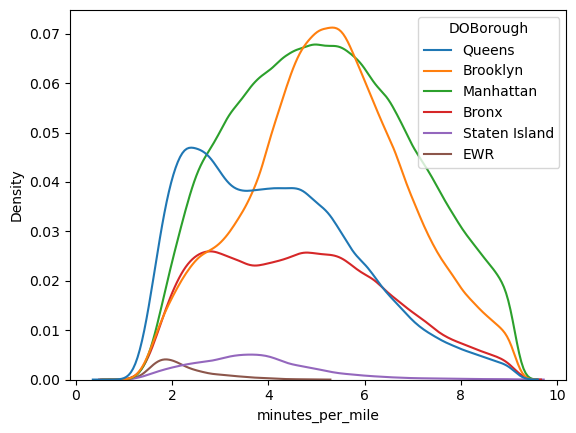

['Queens', 'Brooklyn'] : -0.6367291880566918
['Queens', 'Manhattan'] : -0.5803754207788527
['Queens', 'Bronx'] : -0.2968040966612678
['Queens', 'Staten Island'] : 0.24664823333114252
['Queens', 'EWR'] : 1.127732355294874
['Brooklyn', 'Manhattan'] : 0.01719943597093361
['Brooklyn', 'Bronx'] : 0.320628023978793
['Brooklyn', 'Staten Island'] : 0.9113700353590003
['Brooklyn', 'EWR'] : 1.8297589184157945
['Manhattan', 'Bronx'] : 0.2830688683260883
['Manhattan', 'Staten Island'] : 0.8059023785204669
['Manhattan', 'EWR'] : 1.6316617618776375
['Bronx', 'Staten Island'] : 0.5309426546344047
['Bronx', 'EWR'] : 1.3679007154487586
['Staten Island', 'EWR'] : 1.2616540617219338


skyc1


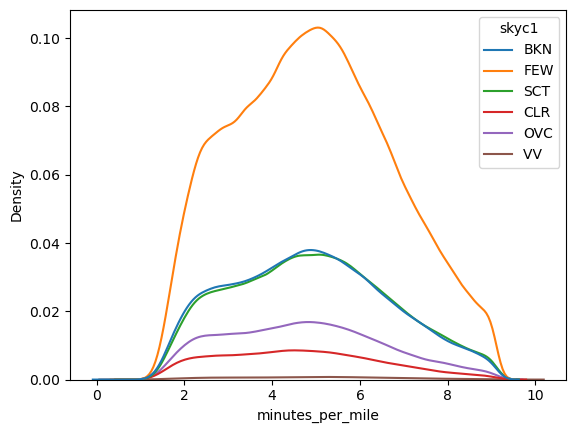

['BKN', 'FEW'] : -0.04254343785581823
['BKN', 'SCT'] : -0.0329549173298406
['BKN', 'CLR'] : 0.13231127342631605
['BKN', 'OVC'] : 0.07500591942012437
['BKN', 'VV '] : -0.012356578731695265
['FEW', 'SCT'] : 0.009593388109633788
['FEW', 'CLR'] : 0.17466666058781494
['FEW', 'OVC'] : 0.11741275403793489
['FEW', 'VV '] : 0.03018305803587985
['SCT', 'CLR'] : 0.16509977311831717
['SCT', 'OVC'] : 0.10794018339953336
['SCT', 'VV '] : 0.020584978689579612
['CLR', 'OVC'] : -0.057678199213833756
['CLR', 'VV '] : -0.1446454896149847
['OVC', 'VV '] : -0.08769538161959264


skyc2


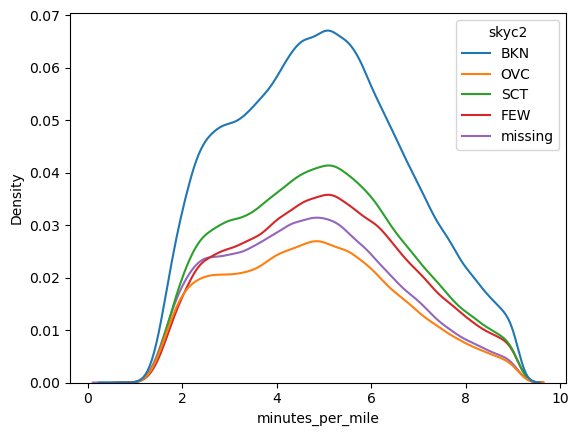

['BKN', 'OVC'] : 0.09469164775065086
['BKN', 'SCT'] : -0.0024073945227178384
['BKN', 'FEW'] : -0.037662128904695065
['BKN', 'missing'] : 0.10859039204785542
['OVC', 'SCT'] : -0.09715266543712829
['OVC', 'FEW'] : -0.13204175926433784
['OVC', 'missing'] : 0.013626725232667024
['SCT', 'FEW'] : -0.03524990603290411
['SCT', 'missing'] : 0.11119599832904883
['FEW', 'missing'] : 0.14627599000587052


skyc3


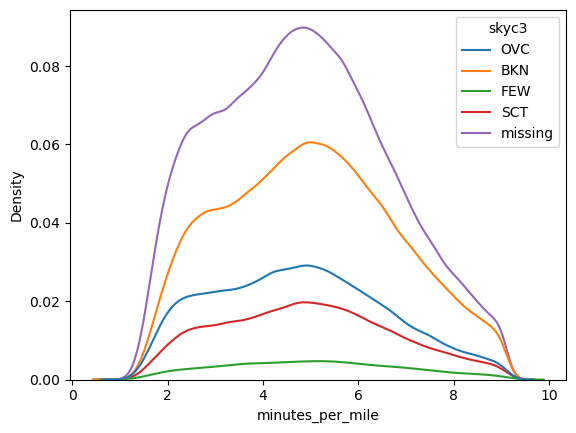

['OVC', 'BKN'] : -0.12689612986878585
['OVC', 'FEW'] : -0.14442206423426598
['OVC', 'SCT'] : -0.08856548067599176
['OVC', 'missing'] : -0.030742213445553813
['BKN', 'FEW'] : -0.017251939272884886
['BKN', 'SCT'] : 0.038765918588129486
['BKN', 'missing'] : 0.09619345438900664
['FEW', 'SCT'] : 0.05616278621362476
['FEW', 'missing'] : 0.11354425950174699
['SCT', 'missing'] : 0.05755038650161752


PUservice_zone


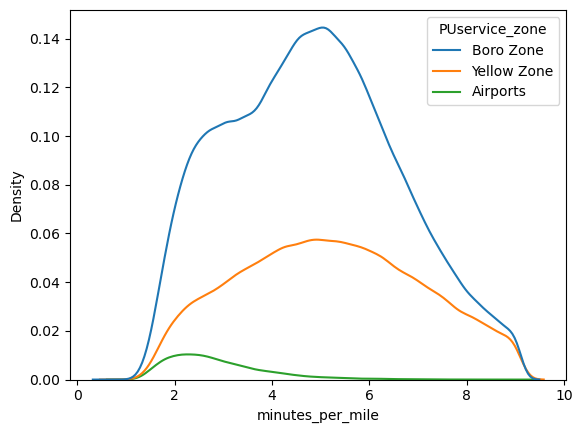

['Boro Zone', 'Yellow Zone'] : -0.2024316845561984
['Boro Zone', 'Airports'] : 1.1472272337337317
['Yellow Zone', 'Airports'] : 1.298206182636012


DOservice_zone


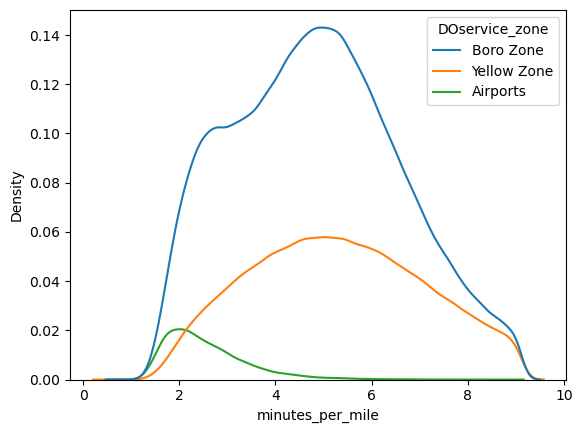

['Boro Zone', 'Yellow Zone'] : -0.25615134201892553
['Boro Zone', 'Airports'] : 1.3371090332145705
['Yellow Zone', 'Airports'] : 1.5962179379595989


visibility


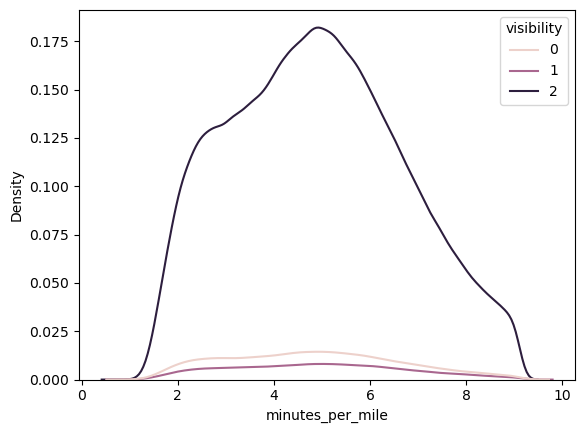

[2, 1] : -0.0036824695366495996
[2, 0] : 0.046389231447903835
[1, 0] : 0.05031893429199269


precipitation


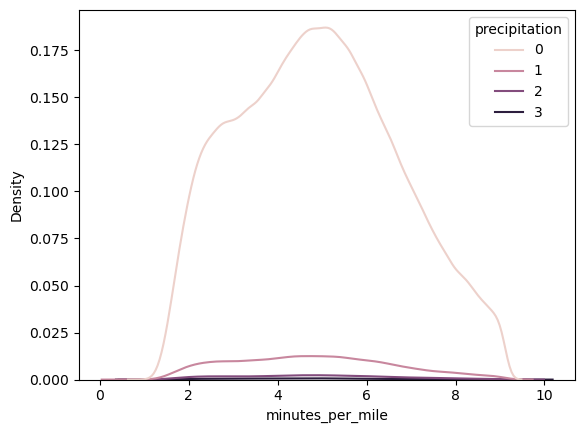

[0, 1] : 0.07172120123972732
[0, 2] : 0.07426271144916105
[0, 3] : 0.15177059512830546
[1, 2] : 0.0026220775626119492
[1, 3] : 0.0812972300531868
[2, 3] : 0.07905281520203246


snowdepth


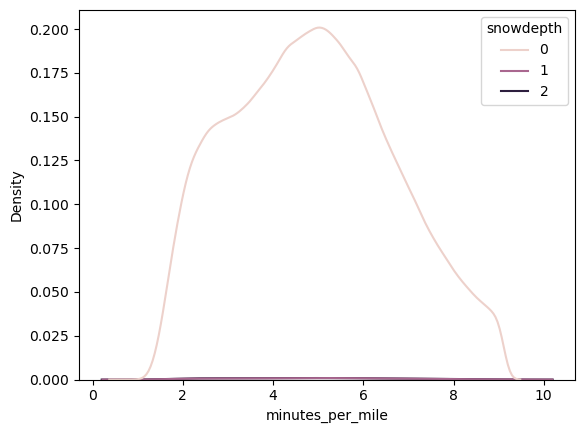

[0, 2] : 0.030129458838964406
[0, 1] : 0.04405572773986607
[2, 1] : 0.013615374122962884


In [83]:
for column in low_nominal:
    nominal_bivariate_analysis(combined_df, column, 'minutes_per_mile')